- Welcome to Quantitative and High Frequency Trading Training Program
- In this week, we will


- Add rolling maximum and minimum to the data
- Test 5 predictive signals and generate each result
- Compare the resutls to see which signal perform the best
- Compare each day's result to check which days perform the best or worst
- Make some adjustments to the signals and check out the result
- Repeat the process to another data set I give you, each person may have different data sets


- We can repeat some of the process of week 2


- Change the path of helper.r if needed

In [199]:
from helper_week_03 import *

## if change information in helper_week_02 then
import helper_week_03
from imp import reload   
reload(helper_week_03)
print(NIGHT_PATH)

d:/intern/night pkl tick/


- number of cores, set this number according to your computer

In [2]:
CORE_NUM = 16

- sample product, you can change to your specific product symbol

In [3]:
product = "j"

- get all of the dates

In [4]:
import os
night_list = list(map(lambda x: NIGHT_PATH+product+"/"+x, os.listdir(NIGHT_PATH + product)))

- get good night date

In [5]:
good_night = load(HEAD_PATH+"/good.night.pkl")

- now it's see why we use this kind of data

In [6]:
good_night_list = good_night[good_night["good.night"]==True]
n_good_night = len(good_night_list)
n_good_night
## 704

704

- we randomly choose a day

In [7]:
data = load(good_night_list.iloc[599]["file.path"])

In [8]:
data.columns

Index(['market', 'contract', 'date.time', 'price', 'cum.open.int', 'open.int',
       'turnover', 'qty', 'open.symbol', 'close.symbol', 'type', 'dire', 'bid',
       'ask', 'bid.qty', 'ask.qty', 'date', 'time', 'milli', 'mid.price',
       'buy.trade', 'buy2.trade', 'sell.trade', 'sell2.trade', 'log.price',
       'ret', 'wpr', 'wpr.ret', 'next.bid', 'next.ask', 'good', 'min.1024',
       'max.1024', 'min.2048', 'max.2048', 'min.4096', 'max.4096'],
      dtype='object')

- Add rolling maximum and minimum to the data

In [28]:
period_list = [1024, 2048, 4096]

In [29]:
def add_min_max(file, period_list):
    data = load(file)
    for period in period_list:
        data["min."+str(period)] = data["wpr"].rolling(period).min()
        #data.loc[:period-1, ("min."+str(period))] = np.minimum.accumulate(data["wpr"].iloc[:period-1])
        data.loc[:period-1, ("min."+str(period))] = data["wpr"][0]
        
        data["max."+str(period)] = data["wpr"].rolling(period).max()
        #data.loc[:period-1, ("max."+str(period))] = np.maximum.accumulate(data["wpr"].iloc[:period-1])
        data.loc[:period-1, ("max."+str(period))] = data["wpr"][0]
    
    save(data, file)

In [9]:
import dask
from dask import compute, delayed

In [31]:
%%time
import functools
with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
    f_par = functools.partial(add_min_max, period_list=period_list)
    compute([delayed(f_par)(file) for file in night_list])

Wall time: 1min 20s


- now let's see the result

In [122]:
print(good_night_list.iloc[600])
# file.path     d:/intern/night pkl tick/j/20180627.pkl
# good.night                                       True
# Name: 607, dtype: object


data = load(good_night_list.iloc[600]["file.path"])


file.path     d:/intern/night pkl tick/j/20180627.pkl
good.night                                       True
Name: 607, dtype: object


In [33]:
data.columns
## [1] "market"       "contract"     "date.time"    "price"        "cum.open.int" "open.int"     "turnover"    
## [8] "qty"          "open.symbol"  "close.symbol" "type"         "dire"         "bid"          "ask"         
## [15] "bid.qty"      "ask.qty"      "date"         "time"         "milli"        "mid.price"    "buy.trade"   
## [22] "buy2.trade"   "sell.trade"   "sell2.trade"  "log.price"    "ret"          "wpr"          "wpr.ret"     
## [29] "next.bid"     "next.ask"     "good"         "min.2048"     "max.2048"     "min.1024"     "max.1024"    
## [36] "min.4096"     "max.4096" 

Index(['market', 'contract', 'date.time', 'price', 'cum.open.int', 'open.int',
       'turnover', 'qty', 'open.symbol', 'close.symbol', 'type', 'dire', 'bid',
       'ask', 'bid.qty', 'ask.qty', 'date', 'time', 'milli', 'mid.price',
       'buy.trade', 'buy2.trade', 'sell.trade', 'sell2.trade', 'log.price',
       'ret', 'wpr', 'wpr.ret', 'next.bid', 'next.ask', 'good', 'min.1024',
       'max.1024', 'min.2048', 'max.2048', 'min.4096', 'max.4096'],
      dtype='object')

- we can find min/max at the end of the columns
- now let's check the result by plotting

- plot the wpr

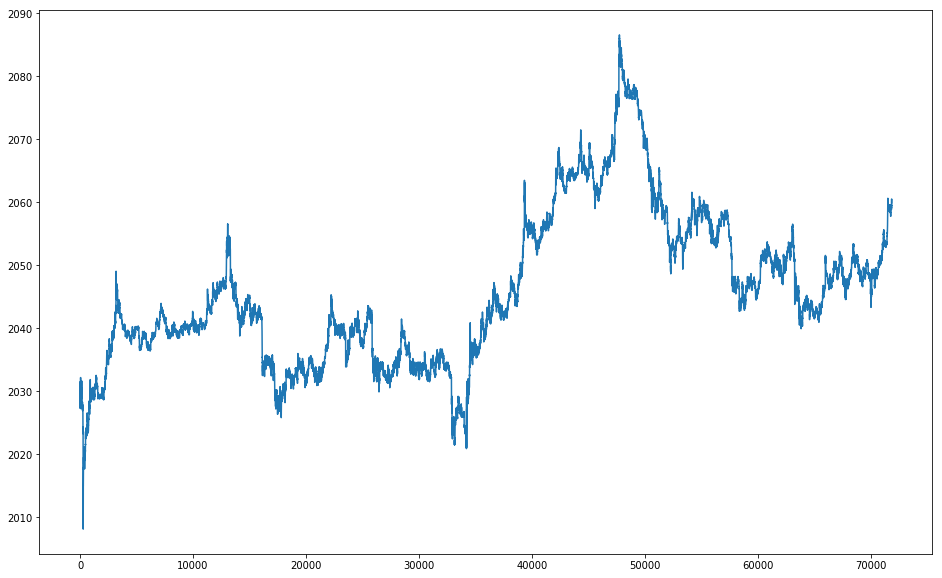

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(1, figsize=(16, 10))
plt.plot(data["wpr"].values);

- plot the maximum price of 2048 ticks
- plot the minimum price of 2048 ticks

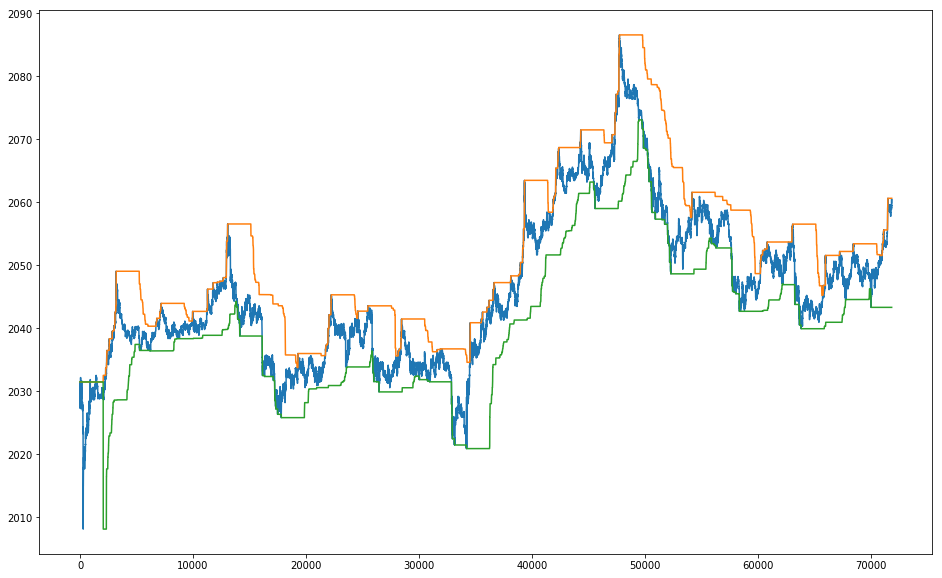

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(1, figsize=(16, 10))
plt.plot(data["wpr"].values)
plt.plot(data["max.2048"].values)
plt.plot(data["min.2048"].values);

## we can see the result meets our expectation
## it may take long time to calculate the min and max of wpr prices
## I give you the estimated time of using 4 cores, so you can deal with other affairs while waiting for result
## but signals using min/max would be sometimes very useful
## the the time to calculating min/max pay off in the end
## In practice, when using c++ to calculating min/max on a rolling basis
## there would be some efficient algorithm, which is faster than comparing all numbers at every tick
## we would talk about it later in our C++ class

- Test 5 predictive signals and generate each result
- now let's see the first signal, which is simply related to price action without trading volume


- set the sample period length

In [36]:
period = 2048

- the first signal

In [37]:
def nr_period(ret, period):
    return zero_divide(ewma(ret, period), ewma(ret.abs(), period))
## it's the cumulative return divided by the absolute value of the return
## here we take the ewma rather than cumulative 
## becuase after the division the value of period legnth is cancelled
## since we have efficient algorithm to calcualte ewma so we use it instead
## the name "nr" means "normalized return"

- now let's see the sample signal

In [38]:
sample_signal = nr_period(data["wpr.ret"], period).values

- check its correctness

In [39]:
sum(np.isnan(sample_signal))
## 0
## so the signal is correct

0

- now let's plot the signal

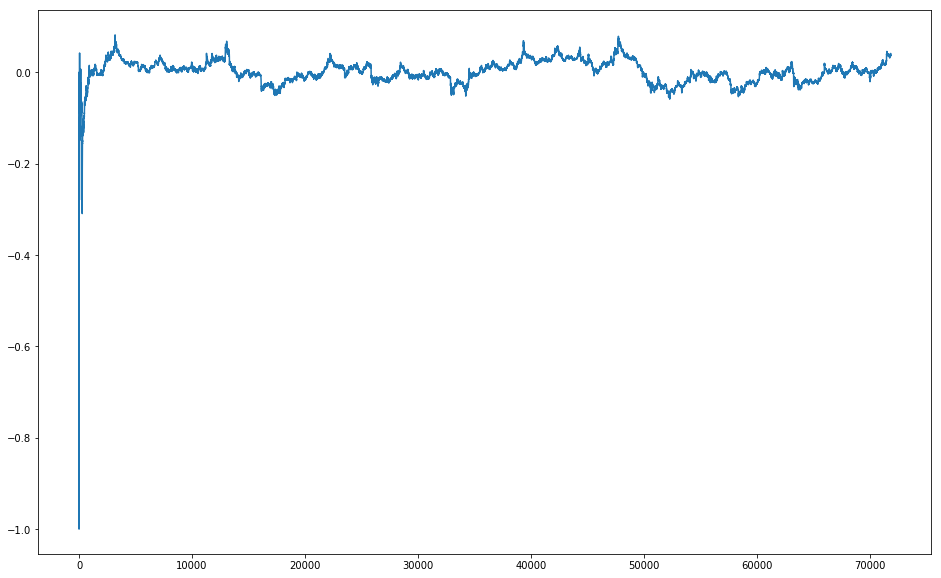

In [40]:
plt.figure(1, figsize=(16, 10))
plt.plot(sample_signal);
## we can see that first few values are bad
## however we are only interested in the values in the middle
## because the first few values are simply for warmup

- we can check the values of interest

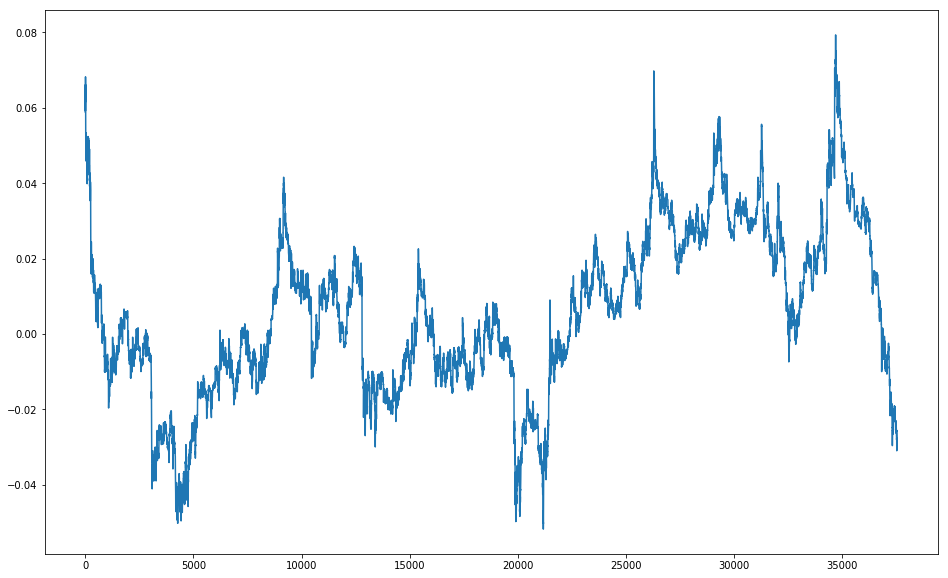

In [41]:
plt.figure(1, figsize=(16, 10))
plt.plot(sample_signal[data["good"]]);
## we can see that it's much better now

- then we follow week 2 and build up the signal
- remember that in week 2 we write a function to calculate the values of all data files

In [10]:
def get_trade_imb(file, product, period):
    data = load(file)
    
    imb = zero_divide(data["buy.trade"] - data["sell.trade"], data["buy.trade"] + data["sell.trade"])
    total_imb = ewma(imb, period)
    S = total_imb[data["good"]].values
    
    save(S, HEAD_PATH+"/tmp pkl/"+product+"/trade.imb."+str(period)+"/" + file[-12:])

- can we have a better way to do this?
- we can write a list to do this

In [11]:
import inspect
from collections import OrderedDict

class factor_template(object):
    factor_name = ""
    
    params = OrderedDict([
        ("period", np.power(2, range(10,13)))
    ])
    
    def formula(self):
        pass  
    
    def form_info(self):
        return inspect.getsource(self.formula)
    
    def info(self):
        info = ""
        info = info + "factor_name:\n"
        info = info +self.factor_name+"\n"
        info = info +"\n"
        info = info + "formula:\n"
        info = info +self.form_info()+"\n"
        info = info +"\n"
        info = info + "params:\n"
        for key in self.params.keys():
            info = info+"$"+key+":"+str(self.params.get(key))+"\n"
        return info
        
    def __repr__(self):
        return self.info()
    
    def __str__(self):
        return self.info()

In [12]:
from collections import OrderedDict
class foctor_nr_period(factor_template):
    factor_name = "nr.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(10,13)))
    ])
    
    def formula(self, data, period):
        return zero_divide(ewma(data["ret"], period), ewma(data["ret"].abs(), period)).values

- let's see waht it looks like

In [13]:
x2 = foctor_nr_period()
x2
# factor_name:
# nr.period

# formula:
#     def formula(self, data, period):
#         return zero_divide(ewma(data["ret"], period), ewma(data["ret"].abs(), period)).values


# params:
# $period:[1024 2048 4096]

factor_name:
nr.period

formula:
    def formula(self, data, period):
        return zero_divide(ewma(data["ret"], period), ewma(data["ret"].abs(), period)).values


params:
$period:[1024 2048 4096]

- the signal has two parts: one is the formula, the other is the values of look-back periods

- to get the formula, we need to use "[[]]"

In [14]:
form = x2.form_info()
print(form)
# def formula(self, data, period):
#         return zero_divide(ewma(data["ret"], period), ewma(data["ret"].abs(), period)).values


    def formula(self, data, period):
        return zero_divide(ewma(data["ret"], period), ewma(data["ret"].abs(), period)).values



- currently we only support signals with one paramter
- as the course going further, we can see how to suppport signals with more paramters
- but signals with more paramters may also lead to the problem of overfitting
- some people claim that they have 10s, 100s, 1000s, etc signals
- most of them may be simply generated in such format, that one formula generates multiple signals
- those signals are usually highly correlated
- to avoid overfitting, I would suggest at first simply use one function for one signal to build a model
- in later course I would talk about how to build up a model

- at first we need to create path for a signal

In [15]:
import itertools

def create_signal_path(signal_list, product, HEAD_PATH):
    keys = list(signal_list.params.keys())
    
    for cartesian in itertools.product(*signal_list.params.values()):
        signal_name = signal_list.factor_name
        for i in range(len(cartesian)):
            signal_name = signal_name.replace(keys[i], str(cartesian[i]))
        
        os.makedirs(HEAD_PATH+"/tmp pkl/"+product+"/"+signal_name, exist_ok=True)

- then we can create path for each signal
- in this way when we calculate signal values we don't need to check the directory problem

In [54]:
create_signal_path(x2, product, HEAD_PATH)

In [16]:
def build_simple_signal(file_name, signal_list, product, HEAD_PATH):
    keys = list(signal_list.params.keys())
    
    data = load(file_name)
    for cartesian in itertools.product(*signal_list.params.values()):
        signal_name = signal_list.factor_name
        for i in range(len(cartesian)):
            signal_name = signal_name.replace(keys[i], str(cartesian[i]))
        
        path = HEAD_PATH+"/tmp pkl/"+product+"/"+signal_name+"/"+file_name[-12:]
        S = signal_list.formula(data, *cartesian)[data["good"]]
        save(S, path)

In [56]:
%%time
with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
    f_par = functools.partial(build_simple_signal, signal_list=x2, product=product, HEAD_PATH=HEAD_PATH)
    compute([delayed(f_par)(file) for file in good_night_list["file.path"]])

Wall time: 1min 29s


- we can see it doesn't take long time to calculate the signal
- and this way can be generalized to calculate other signals

- get the good night files as in week 2

In [17]:
good_night_files = np.array([x[-12:] for x in good_night_list["file.path"]])
good_night_files[:6]
## [1] "20151201.RData" "20151202.RData" "20151203.RData" "20151204.RData"
## [5] "20151207.RData" "20151208.RData"

array(['20151201.pkl', '20151202.pkl', '20151203.pkl', '20151204.pkl',
       '20151207.pkl', '20151208.pkl'], dtype='<U12')

- we set the signal name

In [18]:
signal_name = "nr.2048"

- we can check the value range of the signal
- for example, we choose one day every 10 days 

In [19]:
to_choose = (np.arange(n_good_night)+1) % 10 == 0
all_signal = np.array([])
for file in good_night_files[to_choose]:
    S = load(HEAD_PATH+"/tmp pkl/"+product+"/"+signal_name+"/"+file)
    all_signal = np.concatenate((all_signal, S), axis=0)

- we can see the total number of all.signal

In [61]:
len(all_signal)
## [1] 2103861
## this is the same as that in week 2

2103861

- we can see the plot of the signal

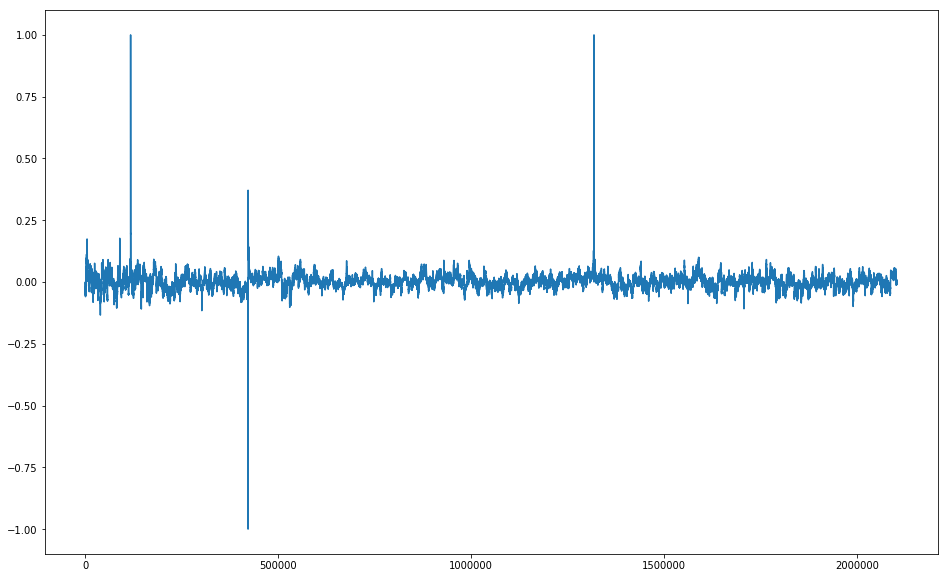

In [62]:
plt.figure(1, figsize=(16, 10))
plt.plot(all_signal);

- generally it's stationary but we can still see some strange values
- we can see how many abnormal values are there
- let's calculate the deviation of the signal

In [20]:
sigma = np.std(all_signal, ddof=1)
sigma
##[1] 0.025461139649662845

0.025461139649662845

- number of signals 

In [64]:
n_signal = len(all_signal)

In [65]:
sum(abs(all_signal)>sigma*1)/n_signal 
##[1] 0.2721943132174607

0.2721943132174607

In [67]:
sum(abs(all_signal)>sigma*2)/n_signal 
##[1] 0.046165122125463615

0.046165122125463615

In [68]:
sum(abs(all_signal)>sigma*3)/n_signal 
##[1] 0.0074187410670191615

0.0074187410670191615

In [69]:
sum(abs(all_signal)>sigma*4)/n_signal 
##[1] 0.002072380257060709

0.002072380257060709

In [70]:
sum(abs(all_signal)>sigma*5)/n_signal 
##[1] 0.0010542521582937276

0.0010542521582937276

In [71]:
sum(abs(all_signal)>sigma*6)/n_signal 
##[1] 0.0004814956881657106

0.0004814956881657106

- we know that sigma*6 is

In [72]:
sigma*6
## 0.15276683789797707

0.15276683789797707

- actually it's not so large according to this graph
- and if we use threshold based on sigma, the sigma would change as data change
- so the threshold would change, that's not good for us

- as a result, we may try to use some fixed threshold
- for example, we could use 0.2 here

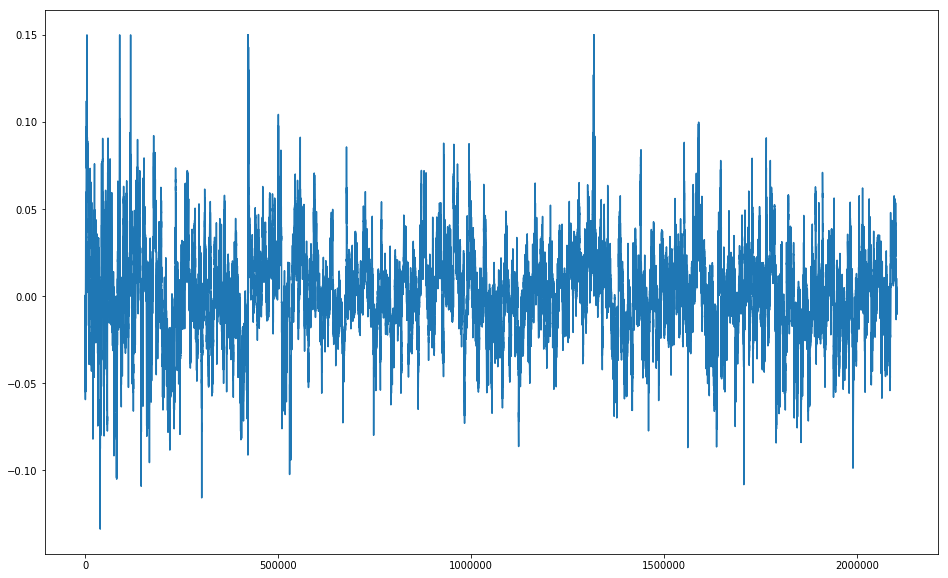

In [21]:
all_signal[abs(all_signal)>0.15] = 0.15
plt.figure(1, figsize=(16, 10))
plt.plot(all_signal);
## it seems much more stationary than before

- we can use a function to cut the threshold 

In [22]:
open_thre = np.arange(0.03, 0.15, 0.01)
thre_mat = pd.DataFrame(data=OrderedDict([("open", open_thre), ("close", -open_thre)]))

In [134]:
open_thre

array([0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11, 0.12, 0.13,
       0.14])

- get training samples

In [40]:
train_sample = good_night_files<"2018"
sum(train_sample)

489

- get testing samples

In [41]:
test_sample = good_night_files>"2018"


In [42]:
from collections import OrderedDict
class foctor_nr_period_vanish(factor_template):
    factor_name = "nr.vanish.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(10,13)))
    ])
    
    def formula(self, data, period):
        return vanish_thre(zero_divide(ewma(data["ret"], period), ewma(data["ret"].abs(), period)), 0.15).values

- we can use nr.vanish.period to make values greater than 0.15 to be 0

In [27]:
x2_2 = foctor_nr_period_vanish()
x2_2

factor_name:
nr.vanish.period

formula:
    def formula(self, data, period):
        return vanish_thre(zero_divide(ewma(data["ret"], period), ewma(data["ret"].abs(), period)), 0.15).values


params:
$period:[1024 2048 4096]

- create directory for vanish signal

In [28]:
create_signal_path(x2_2, product, HEAD_PATH)

- calculate vanish signal

In [29]:
%%time
with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
    f_par = functools.partial(build_simple_signal, signal_list=x2_2, product=product, HEAD_PATH=HEAD_PATH)
    compute([delayed(f_par)(file) for file in good_night_list["file.path"]])

Wall time: 1min 31s


- vanish signal name

In [31]:
signal_vanish_name = "nr.vanish.2048"

In [32]:
%%time
with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
    f_par = functools.partial(get_signal_pnl, product=product, signal_name=signal_vanish_name, thre_mat=thre_mat, reverse=1)
    train_vanish_result = compute([delayed(f_par)(file) for file in good_night_files[train_sample]])[0]

Wall time: 34.5 s


- now we check the result of such vanish signal

In [33]:
train_vanish_stat = get_hft_summary(train_vanish_result, thre_mat, sum(train_sample))

- let's see the result

In [34]:
train_vanish_stat["final.result"]
# open 	close 	num 	avg.pnl 	total.pnl 	sharp 	drawdown 	max.drawdown 	mar
# 0 	0.03 	-0.03 	1414 	0.576713 	815.472280 	0.696570 	202.028205 	566.601100 	1.439235
# 1 	0.04 	-0.04 	987 	1.290864 	1274.082895 	1.198585 	118.954170 	586.490550 	2.172384
# 2 	0.05 	-0.05 	721 	0.393554 	283.752610 	0.262340 	264.212590 	637.675310 	0.444980
# 3 	0.06 	-0.06 	514 	-0.113935 	-58.562405 	-0.065389 	125.619880 	717.387210 	-0.081633
# 4 	0.07 	-0.07 	381 	-0.625253 	-238.221230 	-0.309429 	426.651325 	819.075610 	-0.290842
# 5 	0.08 	-0.08 	268 	-1.138371 	-305.083375 	-0.480204 	449.821570 	567.303025 	-0.537779
# 6 	0.09 	-0.09 	183 	1.148532 	210.181400 	0.409830 	26.783605 	417.160985 	0.503838
# 7 	0.10 	-0.10 	125 	-1.734437 	-216.804595 	-0.445727 	320.361185 	537.650955 	-0.403244
# 8 	0.11 	-0.11 	87 	1.512273 	131.567740 	0.349996 	76.672120 	236.010935 	0.557465
# 9 	0.12 	-0.12 	66 	0.755804 	49.883045 	0.140813 	157.370160 	239.268865 	0.208481
# 10 	0.13 	-0.13 	51 	3.730583 	190.259715 	0.587318 	94.920145 	143.537145 	1.325509
# 11 	0.14 	-0.14 	42 	2.742024 	115.165020 	0.366360 	94.920145 	163.335845 	0.705081

,open,close,num,avg.pnl,total.pnl,sharp,drawdown,max.drawdown,mar
0,0.03,-0.03,1414,0.772611,1092.472280,0.938147,192.029195,523.601980,2.086456
1,0.04,-0.04,987,1.444358,1425.581190,1.347920,119.454115,568.991375,2.505453
2,0.05,-0.05,721,0.615474,443.757010,0.413387,259.711545,580.172725,0.764871
3,0.06,-0.06,514,0.141905,72.938970,0.082297,119.119605,644.887155,0.113103
4,0.07,-0.07,381,-0.457270,-174.220020,-0.226977,372.650005,792.577315,-0.219815
5,0.08,-0.08,268,-0.961130,-257.582770,-0.407565,417.319975,551.802750,-0.466802
6,0.09,-0.09,183,1.347980,246.680355,0.481965,0.000000,402.662250,0.612623
7,0.10,-0.10,125,-1.502451,-187.806355,-0.388044,293.362615,523.652385,-0.358647
8,0.11,-0.11,87,1.483508,129.065155,0.334706,73.672230,249.513300,0.517268
9,0.12,-0.12,66,0.846698,55.882055,0.155657,157.370160,241.769140,0.231138


In [35]:
good_vanish = train_vanish_stat["final.result"]["avg.pnl"]>2
good_vanish[good_vanish]
10    True
11    True
Name: avg.pnl, dtype: bool

10    True
11    True
Name: avg.pnl, dtype: bool

In [36]:
good_pnl = train_vanish_stat["daily.pnl"].loc[:, good_vanish].sum(axis=1)/sum(good_vanish)

- at last we plot the selected pnl

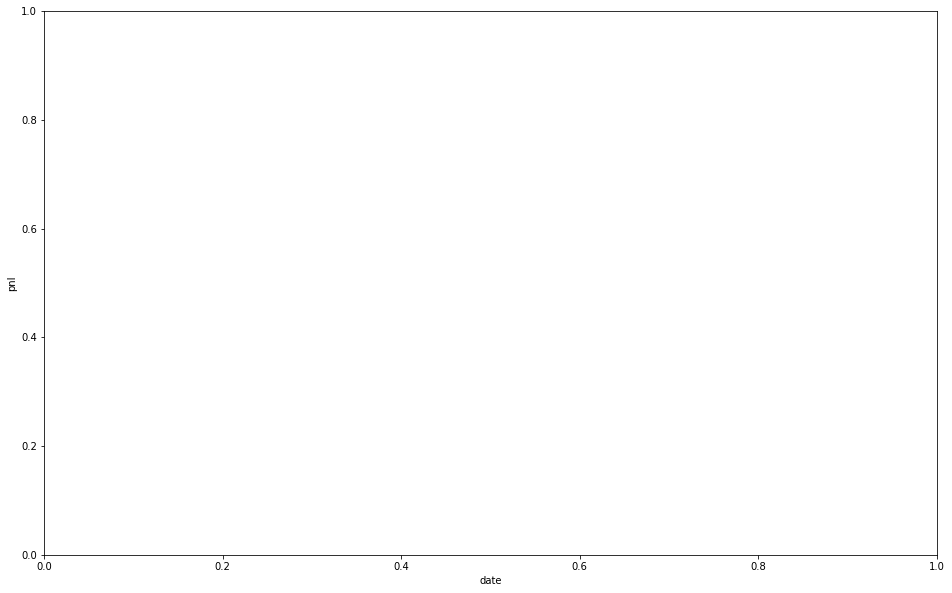

In [241]:
plt.figure(1, figsize=(16, 10))
plt.title("")
plt.xlabel("date")
plt.ylabel("pnl")
date_str = [n[0:8] for n in good_night_files]
format_dates = np.array([pd.to_datetime(d) for d in date_str])
plt.plot(format_dates[train_sample], good_pnl.cumsum());

- now generate the result of vanish signal in test samples

In [43]:
%%time
with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
    f_par = functools.partial(get_signal_pnl, product=product, signal_name=signal_vanish_name, thre_mat=thre_mat, reverse=1)
    test_vanish_result = compute([delayed(f_par)(file) for file in good_night_files[test_sample]])[0]

Wall time: 21.4 s


- get the summary

In [46]:
test_vanish_stat = get_hft_summary(test_vanish_result, thre_mat, sum(test_sample))

- get the good pnl

In [47]:
test_vanish_stat["final.result"][good_vanish]
#  	open 	close 	num 	avg.pnl 	total.pnl 	sharp 	drawdown 	max.drawdown 	mar
# 10 	0.13 	-0.13 	11 	18.343062 	201.77368 	1.854770 	0.0 	30.44374 	6.627756
# 11 	0.14 	-0.14 	9 	17.857840 	160.72056 	1.429767 	0.0 	40.95766 	3.924066

,open,close,num,avg.pnl,total.pnl,sharp,drawdown,max.drawdown,mar
10,0.13,-0.13,11,18.343062,201.77368,1.854770,0.0,30.44374,6.627756
11,0.14,-0.14,9,17.857840,160.72056,1.429767,0.0,40.95766,3.924066


In [48]:
test_vanish_pnl = test_vanish_stat["daily.pnl"].loc[:, good_vanish].sum(axis=1)/sum(good_vanish)

- at last we plot the selected pnl

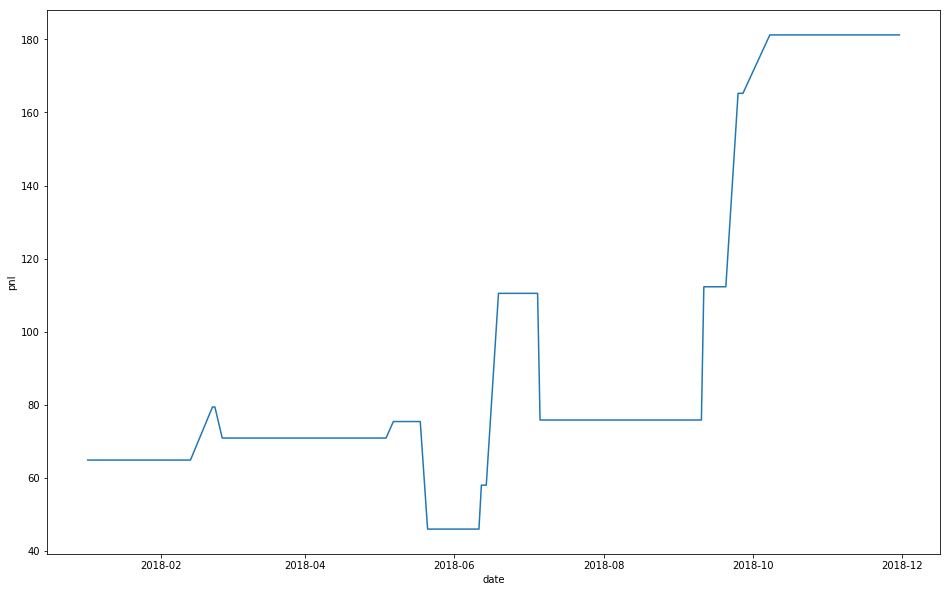

In [105]:
plt.figure(1, figsize=(16, 10))
plt.title("")
plt.xlabel("date")
plt.ylabel("pnl")
plt.plot(format_dates[test_sample], test_vanish_pnl.cumsum());

In [50]:
sharpe(test_vanish_pnl)
## 1.6645745297577983

1.6645745297577983

- later in linear regression, the coefficents are sensitive to thee outliers
- if we set them zero, we can make our estimation of coefficients more robust

- now let's see the second signal


- this signal models the increment of bid/ask size
- here we use bid.qty to reflect bid.size due to some historical reason of naming

In [51]:
from collections import OrderedDict
class foctor_dbook_period(factor_template):
    factor_name = "dbook.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(10,13)))
    ])
    
    def formula(self, data, period):
        diff_bid_qty = data["bid.qty"] - data["bid.qty"].shift()
        diff_bid_qty[0] = 0
        diff_ask_qty = data["ask.qty"] - data["ask.qty"].shift()
        diff_ask_qty[0] = 0
        return ewma(np.sign(diff_bid_qty)-np.sign(diff_ask_qty), period).values

In [52]:
x3 = foctor_dbook_period()
x3

factor_name:
dbook.period

formula:
    def formula(self, data, period):
        diff_bid_qty = data["bid.qty"] - data["bid.qty"].shift()
        diff_bid_qty[0] = 0
        diff_ask_qty = data["ask.qty"] - data["ask.qty"].shift()
        diff_ask_qty[0] = 0
        return ewma(np.sign(diff_bid_qty)-np.sign(diff_ask_qty), period).values


params:
$period:[1024 2048 4096]

- create directory for dbook signal

In [53]:
create_signal_path(x3, product, HEAD_PATH)

In [54]:
%%time
with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
    f_par = functools.partial(build_simple_signal, signal_list=x3, product=product, HEAD_PATH=HEAD_PATH)
    compute([delayed(f_par)(file) for file in good_night_list["file.path"]])

Wall time: 35 s


- now we write the all.signal part into a function

In [57]:
def get_all_signal(good_night_files, product, signal_name):
    n_good_night = len(good_night_files)
    to_choose = (np.arange(n_good_night)+1) % 10 == 0
    all_signal = np.array([])
    for file in good_night_files[to_choose]:
        S = load(HEAD_PATH+"/tmp pkl/"+product+"/"+signal_name+"/"+file)
        all_signal = np.concatenate((all_signal, S), axis=0)
    return all_signal

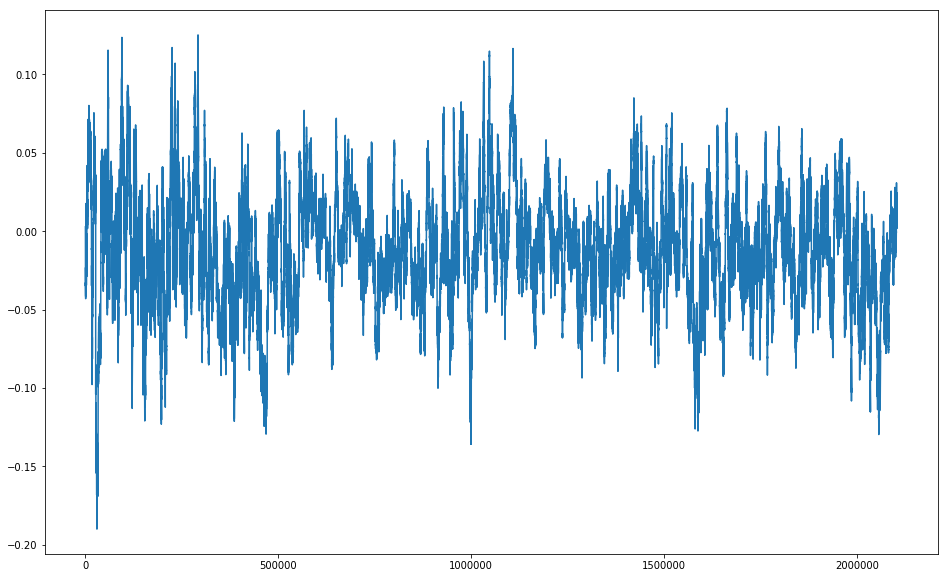

In [58]:
all_signal = get_all_signal(good_night_files, product, "dbook.2048")
plt.figure(1, figsize=(16, 10))
plt.plot(all_signal);

- there is no extreme values

In [60]:
open_thre = np.arange(0.05, 0.11, 0.005)
thre_mat = pd.DataFrame(data=OrderedDict([("open", open_thre), ("close", -open_thre)]))

- get the result of training sample

In [61]:
signal_name = "dbook.2048"

In [62]:
%%time
with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
    f_par = functools.partial(get_signal_pnl, product=product, signal_name=signal_name, thre_mat=thre_mat, reverse=-1)
    train_result = compute([delayed(f_par)(file) for file in good_night_files[train_sample]])[0]

Wall time: 38.1 s


- get the statistics result of training sample

In [74]:
train_stat = get_hft_summary(train_result, thre_mat, sum(train_sample))
train_stat["final.result"]

# open 	close 	num 	avg.pnl 	total.pnl 	sharp 	drawdown 	max.drawdown 	mar
# 0 	0.050 	-0.050 	688 	1.037501 	713.800375 	0.665908 	99.276935 	520.378440 	1.371695
# 1 	0.055 	-0.055 	604 	0.846063 	511.022300 	0.516924 	136.457980 	560.380175 	0.911921
# 2 	0.060 	-0.060 	519 	0.943510 	489.681790 	0.519858 	56.571820 	563.651505 	0.868767
# 3 	0.065 	-0.065 	449 	1.359524 	610.426485 	0.734739 	18.788490 	444.650025 	1.372825
# 4 	0.070 	-0.070 	399 	1.003150 	400.256785 	0.508463 	66.930010 	537.957285 	0.744031
# 5 	0.075 	-0.075 	345 	1.533318 	528.994830 	0.769644 	26.812250 	584.320695 	0.905316
# 6 	0.080 	-0.080 	294 	1.210410 	355.860550 	0.569161 	16.813240 	566.083620 	0.628636
# 7 	0.085 	-0.085 	246 	0.830234 	204.237560 	0.355294 	34.326385 	582.190985 	0.350809
# 8 	0.090 	-0.090 	210 	0.363544 	76.344275 	0.149600 	60.264905 	452.426210 	0.168744
# 9 	0.095 	-0.095 	182 	-0.230768 	-41.999815 	-0.089515 	166.560290 	404.977915 	-0.103709
# 10 	0.100 	-0.100 	152 	0.071479 	10.864745 	0.024669 	122.950580 	356.272290 	0.030496
# 11 	0.105 	-0.105 	129 	0.227813 	29.387855 	0.071881 	97.903230 	287.087235 	0.102366

## we can see that the result is much better than the previous signal
## so we know that signals are different, some are good and some are not so good

,open,close,num,avg.pnl,total.pnl,sharp,drawdown,max.drawdown,mar
0,0.050,-0.050,688,1.037501,713.800375,0.665908,99.276935,520.378440,1.371695
1,0.055,-0.055,604,0.846063,511.022300,0.516924,136.457980,560.380175,0.911921
2,0.060,-0.060,519,0.943510,489.681790,0.519858,56.571820,563.651505,0.868767
3,0.065,-0.065,449,1.359524,610.426485,0.734739,18.788490,444.650025,1.372825
4,0.070,-0.070,399,1.003150,400.256785,0.508463,66.930010,537.957285,0.744031
5,0.075,-0.075,345,1.533318,528.994830,0.769644,26.812250,584.320695,0.905316
6,0.080,-0.080,294,1.210410,355.860550,0.569161,16.813240,566.083620,0.628636
7,0.085,-0.085,246,0.830234,204.237560,0.355294,34.326385,582.190985,0.350809
8,0.090,-0.090,210,0.363544,76.344275,0.149600,60.264905,452.426210,0.168744
9,0.095,-0.095,182,-0.230768,-41.999815,-0.089515,166.560290,404.977915,-0.103709


- let's see how many good signals there are

In [85]:
good_strat = train_stat["final.result"]["avg.pnl"]>1
good_strat
# 0      True
# 1     False
# 2     False
# 3      True
# 4      True
# 5      True
# 6      True
# 7     False
# 8     False
# 9     False
# 10    False
# 11    False
# Name: avg.pnl, dtype: bool

0      True
1     False
2     False
3      True
4      True
5      True
6      True
7     False
8     False
9     False
10    False
11    False
Name: avg.pnl, dtype: bool

- there are quite many good signals

In [87]:
good_pnl = train_stat["daily.pnl"].loc[:, good_strat].sum(axis=1)
#train_stat["daily.pnl"]

- at last we plot the selected pnl

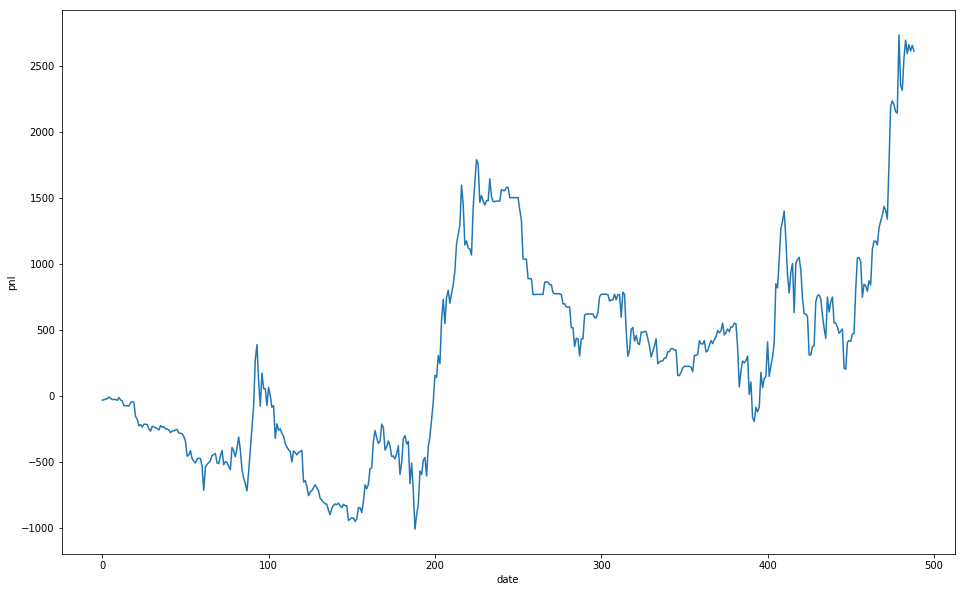

In [88]:
plt.figure(1, figsize=(16, 10))
plt.title("")
plt.xlabel("date")
plt.ylabel("pnl")
format_dates = np.array([pd.to_datetime(d) for d in date_str])
plt.plot(good_pnl.cumsum());
## this plot is pretty good

- we can check its sharp ratio

In [89]:
sharpe(good_pnl)
## 0.734133626110556
## it is as good as the signal of week 2 and it's much better than the previous signal
## remember that we use reverse=-1 here
## for each signal we don't know whether it's positive or negative corelated with the market movement

0.734133626110556

- now let's check how it performs on the test set

In [90]:
%%time
with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
    f_par = functools.partial(get_signal_pnl, product=product, signal_name=signal_name, thre_mat=thre_mat, reverse=-1)
    test_result = compute([delayed(f_par)(file) for file in good_night_files[test_sample]])[0]

Wall time: 35.6 s


In [91]:
test_stat = get_hft_summary(test_result, thre_mat, sum(test_sample))
test_stat["final.result"][good_strat]

# open 	close 	num 	avg.pnl 	total.pnl 	sharp 	drawdown 	max.drawdown 	mar
# 0 	0.050 	-0.050 	367 	0.570978 	209.548800 	0.450563 	144.871365 	402.431065 	0.520707
# 3 	0.065 	-0.065 	230 	4.603624 	1058.833575 	2.697323 	66.047705 	148.532950 	7.128611
# 4 	0.070 	-0.070 	193 	5.603661 	1081.506615 	3.289564 	98.509115 	116.814180 	9.258350
# 5 	0.075 	-0.075 	162 	5.263525 	852.691125 	2.975681 	120.352005 	148.317750 	5.749083
# 6 	0.080 	-0.080 	129 	5.223135 	673.784450 	2.571670 	132.753800 	164.752010 	4.089689

## the result is still quite satisfactory in the test sample

,open,close,num,avg.pnl,total.pnl,sharp,drawdown,max.drawdown,mar
0,0.050,-0.050,367,0.570978,209.548800,0.450563,144.871365,402.431065,0.520707
3,0.065,-0.065,230,4.603624,1058.833575,2.697323,66.047705,148.532950,7.128611
4,0.070,-0.070,193,5.603661,1081.506615,3.289564,98.509115,116.814180,9.258350
5,0.075,-0.075,162,5.263525,852.691125,2.975681,120.352005,148.317750,5.749083
6,0.080,-0.080,129,5.223135,673.784450,2.571670,132.753800,164.752010,4.089689


- now we see the pnl curve

In [92]:
good_pnl = test_stat["daily.pnl"].loc[:, good_strat].sum(axis=1)/sum(good_strat)

- at last we plot the selected pnl

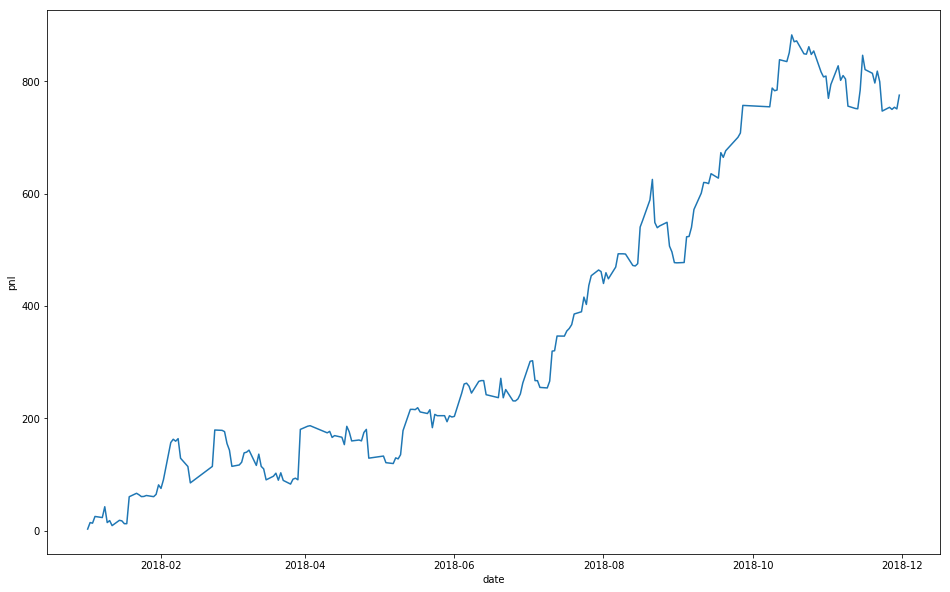

In [93]:
plt.figure(1, figsize=(16, 10))
plt.title("")
plt.xlabel("date")
plt.ylabel("pnl")
plt.plot(format_dates[test_sample], good_pnl.cumsum());
## it's much better than the previous one

In [103]:
sharpe(good_pnl)
## 2.5725349900161727
## it's still quite good for the sharpe ratio

'dbook.2048'

- now we can combine all of these to a function

In [112]:
from collections import OrderedDict
def get_signal_stat(signal_name, thre_mat, product, good_night_files, split_str="2018", reverse=1, min_pnl=2):
    train_sample = good_night_files<split_str
    test_sample = good_night_files>split_str
    with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
        f_par = functools.partial(get_signal_pnl, product=product, signal_name=signal_name, thre_mat=thre_mat, reverse=reverse)
        train_result = compute([delayed(f_par)(file) for file in good_night_files[train_sample]])[0]
    train_stat = get_hft_summary(train_result, thre_mat, sum(train_sample))
    good_strat = train_stat["final.result"]["avg.pnl"]>min_pnl
    print("good strategies: \n", good_strat[good_strat], "\n")
    
    good_pnl = train_stat["daily.pnl"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
    
    print("train sharpe: ", sharpe(good_pnl), "\n")
    
    date_str = [n[0:8] for n in good_night_files]
    format_dates = np.array([pd.to_datetime(d) for d in date_str])
    plt.figure(1, figsize=(16, 10))
    plt.title("train")
    plt.xlabel("date")
    plt.ylabel("pnl")
    plt.plot(format_dates[train_sample], good_pnl.cumsum())
    
    with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
        f_par = functools.partial(get_signal_pnl, product=product, signal_name=signal_name, thre_mat=thre_mat, reverse=reverse)
        test_result = compute([delayed(f_par)(file) for file in good_night_files[test_sample]])[0]
    test_stat = get_hft_summary(test_result, thre_mat, sum(test_sample))
  
    test_pnl = test_stat["daily.pnl"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
   
    print("test sharpe: ", sharpe(test_pnl), "\n")
    
    plt.figure(2, figsize=(16, 10))
    plt.title("test")
    plt.xlabel("date")
    plt.ylabel("pnl")
    plt.plot(format_dates[test_sample], test_pnl.cumsum())
    return OrderedDict([("train.stat", train_stat), ("test.stat", test_stat), ("good.strat", good_strat)])

good strategies: 
 0    True
3    True
4    True
5    True
6    True
Name: avg.pnl, dtype: bool 

train sharpe:  0.7341336261105565 

test sharpe:  2.5725349900161727 



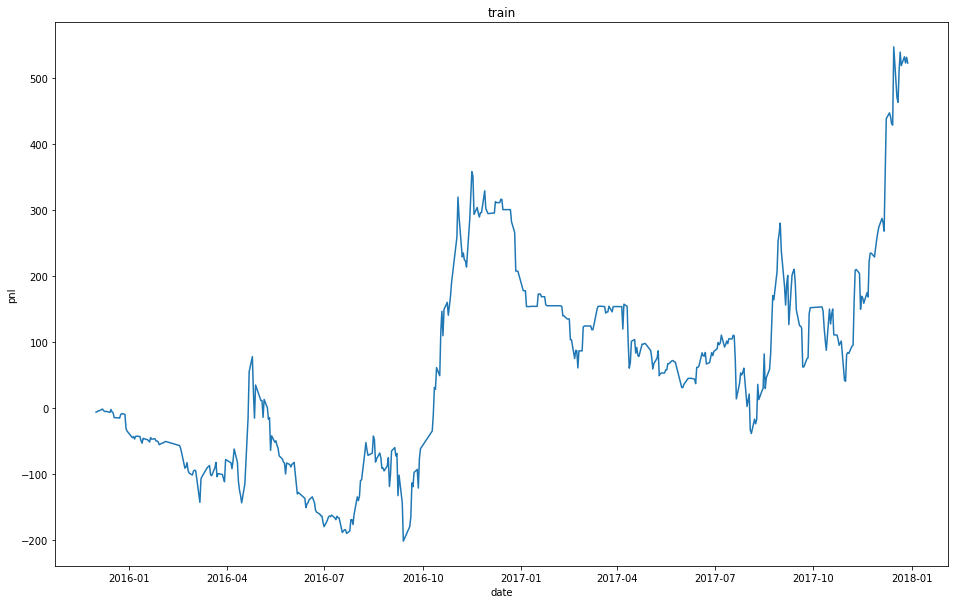

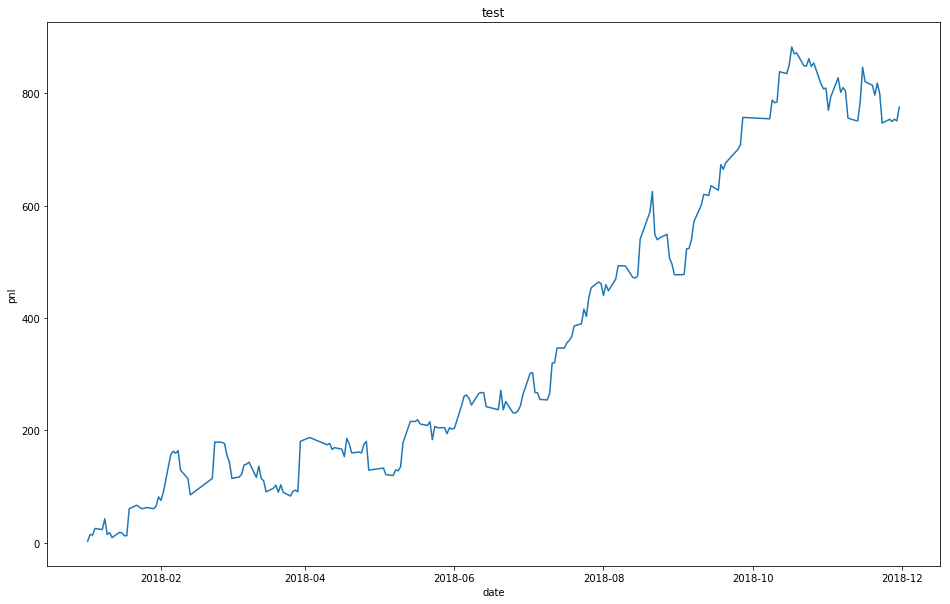

In [113]:
signal_stat = get_signal_stat(signal_name, thre_mat, product, good_night_files, reverse=-1, min_pnl=1)

# good strategies: 
#  0    True
# 3    True
# 4    True
# 5    True
# 6    True
# Name: avg.pnl, dtype: bool 

# train sharpe:  0.7341336261105565 

# test sharpe:  2.5725349900161727 


In [114]:
signal_stat.keys()
## odict_keys(['train.stat', 'test.stat', 'good.strat'])

odict_keys(['train.stat', 'test.stat', 'good.strat'])

- we can test other signals

good strategies: 
 0     True
1     True
2     True
3     True
4     True
7     True
10    True
11    True
Name: avg.pnl, dtype: bool 

train sharpe:  0.774922026056053 

test sharpe:  2.083456999006234 

Wall time: 47.4 s


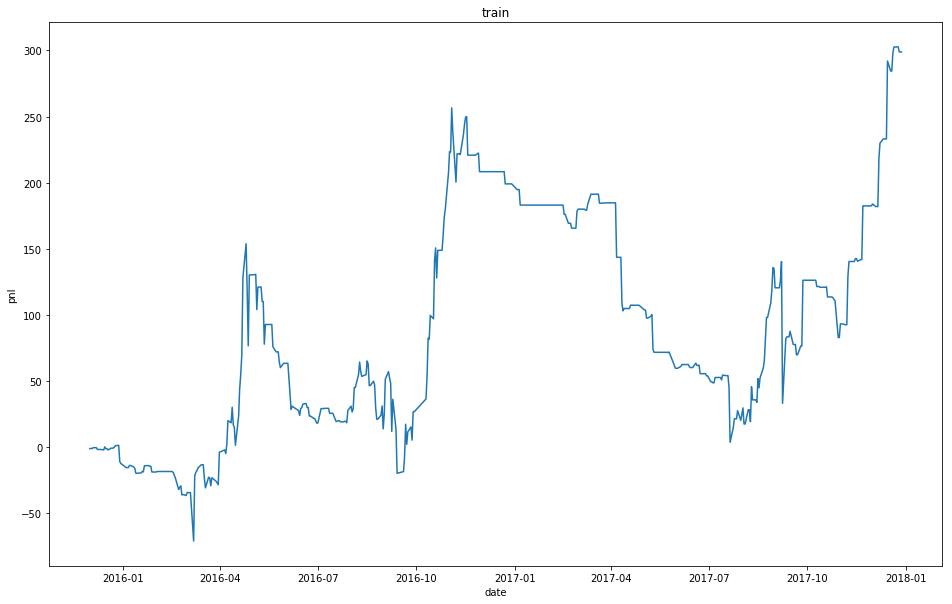

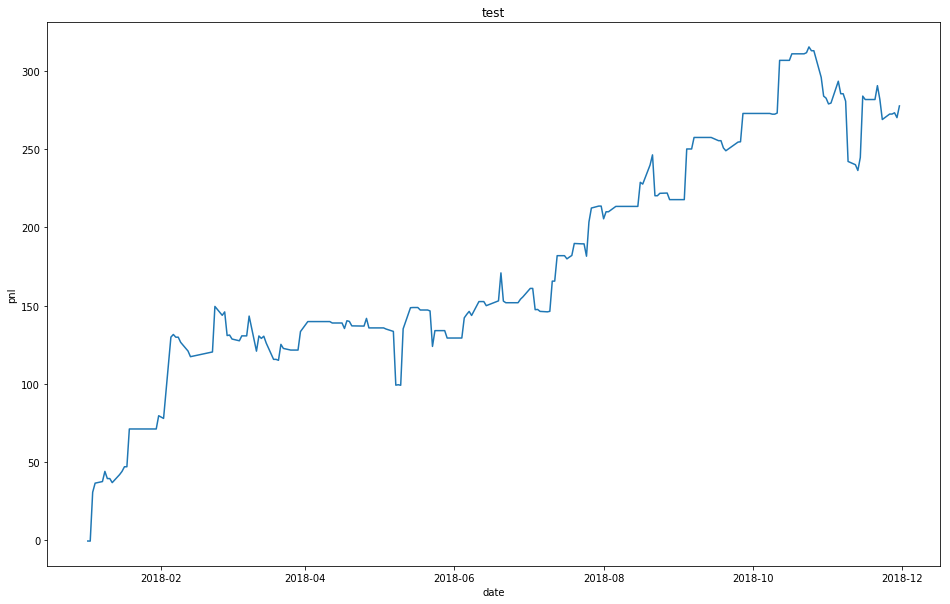

In [116]:
%%time
signal_stat = get_signal_stat("dbook.4096", thre_mat, product, good_night_files, reverse=-1,min_pnl=1)

# good strategies: 
#  0     True
# 1     True
# 2     True
# 3     True
# 4     True
# 7     True
# 10    True
# 11    True
# Name: avg.pnl, dtype: bool 

# train sharpe:  0.774922026056053 

# test sharpe:  2.083456999006234 

# Wall time: 47.4 s



In [117]:
signal_stat["train.stat"]["final.result"]
# open 	close 	num 	avg.pnl 	total.pnl 	sharp 	drawdown 	max.drawdown 	mar
# 0 	0.050 	-0.050 	302 	1.913242 	577.799235 	0.810687 	9.443190 	556.662970 	1.037970
# 1 	0.055 	-0.055 	253 	2.430194 	614.839205 	0.952420 	8.443080 	497.314740 	1.236318
# 2 	0.060 	-0.060 	207 	2.366648 	489.896225 	0.851032 	6.942915 	375.711355 	1.303916
# 3 	0.065 	-0.065 	160 	1.612884 	258.061485 	0.516497 	50.417190 	407.502115 	0.633276
# 4 	0.070 	-0.070 	134 	1.834171 	245.778975 	0.571587 	80.990455 	329.723135 	0.745410
# 5 	0.075 	-0.075 	100 	0.964670 	96.467005 	0.226699 	124.147395 	373.827280 	0.258052
# 6 	0.080 	-0.080 	77 	-0.608634 	-46.864795 	-0.124422 	204.320040 	384.415065 	-0.121912
# 7 	0.085 	-0.085 	57 	1.321844 	75.345135 	0.208688 	140.943035 	323.537565 	0.232879
# 8 	0.090 	-0.090 	38 	-0.860816 	-32.711025 	-0.108270 	225.549410 	279.015360 	-0.117237
# 9 	0.095 	-0.095 	28 	0.352964 	9.883000 	0.038901 	141.081315 	141.081315 	0.070052
# 10 	0.100 	-0.100 	21 	2.903178 	60.966730 	0.258055 	121.025965 	121.025965 	0.503749
# 11 	0.105 	-0.105 	18 	3.818958 	68.741240 	0.294299 	121.526020 	121.526020 	0.565650


## next time we can add total holding time so that we can calcualte average holding time
## then we can have a better idea of how long we keep our position

,open,close,num,avg.pnl,total.pnl,sharp,drawdown,max.drawdown,mar
0,0.050,-0.050,302,1.913242,577.799235,0.810687,9.443190,556.662970,1.037970
1,0.055,-0.055,253,2.430194,614.839205,0.952420,8.443080,497.314740,1.236318
2,0.060,-0.060,207,2.366648,489.896225,0.851032,6.942915,375.711355,1.303916
3,0.065,-0.065,160,1.612884,258.061485,0.516497,50.417190,407.502115,0.633276
4,0.070,-0.070,134,1.834171,245.778975,0.571587,80.990455,329.723135,0.745410
5,0.075,-0.075,100,0.964670,96.467005,0.226699,124.147395,373.827280,0.258052
6,0.080,-0.080,77,-0.608634,-46.864795,-0.124422,204.320040,384.415065,-0.121912
7,0.085,-0.085,57,1.321844,75.345135,0.208688,140.943035,323.537565,0.232879
8,0.090,-0.090,38,-0.860816,-32.711025,-0.108270,225.549410,279.015360,-0.117237
9,0.095,-0.095,28,0.352964,9.883000,0.038901,141.081315,141.081315,0.070052


- now we have this function we can test more signals more conveniently


- currently we have use trade volume (week 2), return (x2), and bid.qty/ask.qty(x3) to construct signals
- another information we have not used is open interest
- we know that open interest has no direct relationship with trade direction
- however, we know if open interest and the trade direction are the same
- it would strenghthen the direction
- otherwise it would weaken the direction


- now we can use this phenomenon to construct  a signal


- let's see an example

- somebody argue that the ewma has not so clear meaning for the formula of lambda
- so here we use another formula, lambda=2/(period+1)
- to save time of calculating lambda for every data set here I simply use another function

In [118]:
def ewma_lambda(x, lambda_, init=0):
    init_s = pd.Series(data=init)
    s = init_s.append(x)
    return s.ewm(alpha=lambda_, adjust=False).mean()[1:]

In [126]:
period=2048
open_int_diff = data["open.int"] - data["open.int"].shift(1)
open_int_diff[0] = 0
aa = ewma_lambda(np.sign(open_int_diff)*np.sign(data["ret"]), 2/(period+1)).values

- check whether it's a valid signal

In [127]:
sum(np.isnan(aa))
## 0

0

- get the plot of this signal

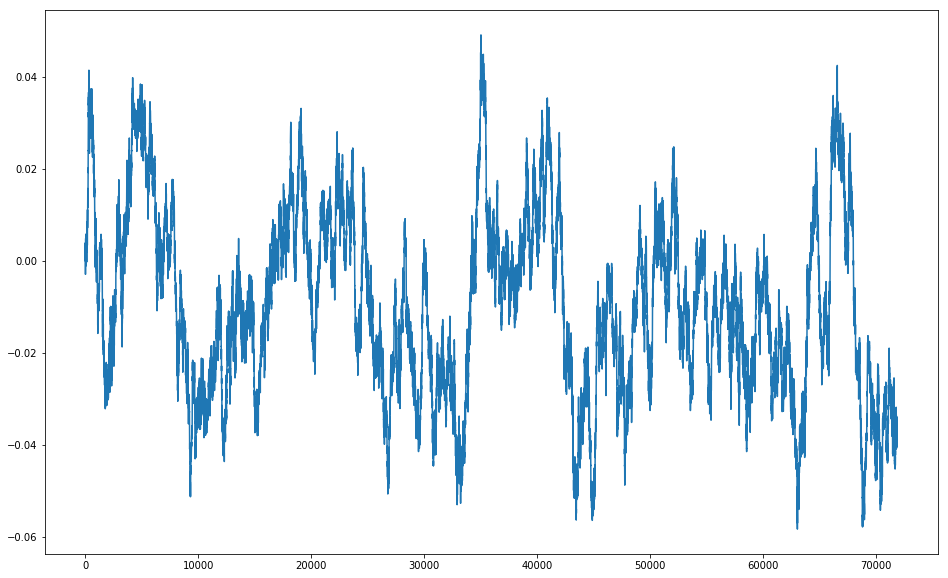

In [128]:
plt.figure(1, figsize=(16, 10))
plt.plot(aa);
## it seems the value of this signal is quite small

In [129]:
from collections import OrderedDict
class foctor_open_int_ret_period(factor_template):
    factor_name = "open.int.ret.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(10,13)))
    ])
    
    def formula(self, data, period):
        open_int_diff = data["open.int"] - data["open.int"].shift(1)
        open_int_diff[0] = 0
        return ewma_lambda(np.sign(open_int_diff)*np.sign(data["ret"]), 2/(period+1)).values

In [130]:
x3_1 = foctor_open_int_ret_period()
x3_1

##[[1]]
##open.int.ret.period ~ ewma.lambda(sign(fill.diff(open.int)) * ret, 2/(period + 1))


##[[2]]
##[[2]]$period
##[1] 1024 2048 4096

factor_name:
open.int.ret.period

formula:
    def formula(self, data, period):
        open_int_diff = data["open.int"] - data["open.int"].shift(1)
        open_int_diff[0] = 0
        return ewma_lambda(np.sign(open_int_diff)*np.sign(data["ret"]), 2/(period+1)).values


params:
$period:[1024 2048 4096]

- then we can create directories for this signal

In [131]:
create_signal_path(x3_1, product, HEAD_PATH)

- then we can calculate the signal values

In [132]:
%%time
with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
    f_par = functools.partial(build_simple_signal, signal_list=x3_1, product=product, HEAD_PATH=HEAD_PATH)
    compute([delayed(f_par)(file) for file in good_night_list["file.path"]])

Wall time: 33.9 s


- now we can check the values of the signal

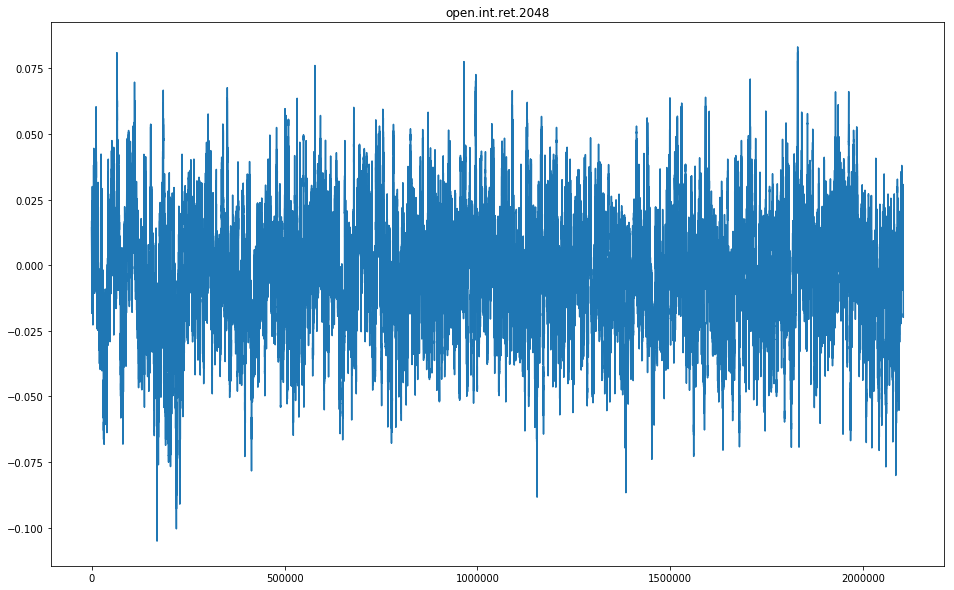

In [133]:
all_signal = get_all_signal(good_night_files, product, "open.int.ret.2048")
plt.figure(1, figsize=(16, 10))
plt.title("open.int.ret.2048")
plt.plot(all_signal);

- it seems we should use 1e-5 as threshold, all above which should be set zero

In [144]:
from collections import OrderedDict
class foctor_open_int_ret_period_vanish(factor_template):
    factor_name = "open.int.ret.vanish.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(10,13)))
    ])
    
    def formula(self, data, period):
        open_int_diff = data["open.int"] - data["open.int"].shift(1)
        open_int_diff[0] = 0
        return vanish_thre(ewma_lambda(np.sign(open_int_diff)*np.sign(data["ret"]), 2/(period+1)), 0.7).values

In [145]:
x3_2 = foctor_open_int_ret_period_vanish()
x3_2

# factor_name:
# open.int.ret.vanish.period

# formula:
#     def formula(self, data, period):
#         open_int_diff = data["open.int"] - data["open.int"].shift(1)
#         open_int_diff[0] = 0
#         return vanish_thre(ewma_lambda(np.sign(open_int_diff)*np.sign(data["ret"]), 2/(period+1)), 0.7).values


# params:
# $period:[1024 2048 4096]

factor_name:
open.int.ret.vanish.period

formula:
    def formula(self, data, period):
        open_int_diff = data["open.int"] - data["open.int"].shift(1)
        open_int_diff[0] = 0
        return vanish_thre(ewma_lambda(np.sign(open_int_diff)*np.sign(data["ret"]), 2/(period+1)), 0.7).values


params:
$period:[1024 2048 4096]

- then we can create directories for this signal

In [146]:
create_signal_path(x3_2, product, HEAD_PATH)

- then we can calculate the signal values

In [147]:
%%time
with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
    f_par = functools.partial(build_simple_signal, signal_list=x3_2, product=product, HEAD_PATH=HEAD_PATH)
    compute([delayed(f_par)(file) for file in good_night_list["file.path"]])

Wall time: 35.8 s


- plot the signal

array([-0.01565139, -0.01563611, -0.01562085, -0.0156056 , -0.01656645,
       -0.0155742 , -0.015559  , -0.01554381, -0.01552864, -0.01551348,
       -0.01549834, -0.01548321, -0.0154681 , -0.01642908, -0.01543696,
       -0.01542189, -0.01540684, -0.0153918 , -0.01537678])

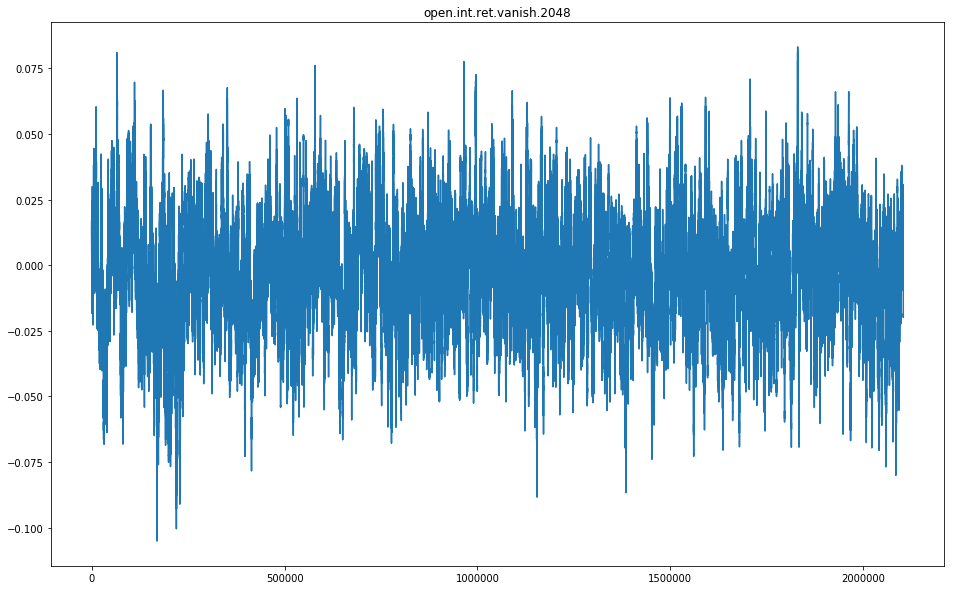

In [213]:
all_signal = get_all_signal(good_night_files, product, "open.int.ret.vanish.2048")
plt.figure(1, figsize=(16, 10))
plt.title("open.int.ret.vanish.2048")
plt.plot(all_signal);
all_signal[1001:1020]

- there is no extreme values

In [163]:
open_thre = np.arange(0.04, 0.072, 0.002)

thre_mat = pd.DataFrame(data=OrderedDict([("open", open_thre), ("close", -open_thre)]))

- now we can check the training result
- here we use get_signal_pnl_better, it's generally the same as get_signal_pnl
- but for some spectial points, like 10:15,11:30 it would not trade
- because they are end of sessions and order may not arrive at exchange in time

In [171]:
%%time
with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
    f_par = functools.partial(get_signal_pnl_better, product=product, signal_name="open.int.ret.vanish.2048", thre_mat=thre_mat,
                              reverse=1, min_spread=0.51)
    train_result = compute([delayed(f_par)(file) for file in good_night_files[train_sample]])[0]

Wall time: 44.4 s


In [172]:
train_stat = get_hft_summary(train_result, thre_mat, sum(train_sample))
train_stat["final.result"]
# 
# open 	close 	num 	avg.pnl 	total.pnl 	sharp 	drawdown 	max.drawdown 	mar
# 0 	0.040 	-0.040 	1048 	0.227609 	238.534345 	0.213170 	321.168645 	522.471050 	0.456550
# 1 	0.042 	-0.042 	918 	0.518124 	475.638065 	0.425709 	231.828565 	370.726055 	1.282991
# 2 	0.044 	-0.044 	818 	1.028177 	841.048710 	0.801923 	143.517305 	315.531300 	2.665500
# 3 	0.046 	-0.046 	706 	0.614190 	433.617790 	0.411730 	280.218810 	581.861140 	0.745226
# 4 	0.048 	-0.048 	605 	0.103686 	62.730120 	0.060689 	278.991550 	455.650135 	0.137672
# 5 	0.050 	-0.050 	500 	0.748803 	374.401605 	0.379067 	257.815210 	429.909970 	0.870884
# 6 	0.052 	-0.052 	438 	0.514032 	225.146170 	0.241229 	188.135530 	416.186630 	0.540974
# 7 	0.054 	-0.054 	371 	1.501432 	557.031340 	0.677365 	230.426975 	347.270635 	1.604027
# 8 	0.056 	-0.056 	313 	1.104093 	345.581190 	0.445555 	286.825910 	346.433475 	0.997540
# 9 	0.058 	-0.058 	257 	1.823178 	468.556740 	0.625682 	135.696295 	287.974395 	1.627078
# 10 	0.060 	-0.060 	217 	1.050170 	227.886885 	0.327667 	257.423590 	311.877825 	0.730693
# 11 	0.062 	-0.062 	181 	0.580883 	105.139895 	0.166568 	213.562835 	304.333845 	0.345476
# 12 	0.064 	-0.064 	151 	-0.644915 	-97.382175 	-0.186276 	176.508960 	461.341780 	-0.211085
# 13 	0.066 	-0.066 	131 	-1.048351 	-137.333930 	-0.271902 	220.059010 	513.124065 	-0.267643
# 14 	0.068 	-0.068 	106 	-0.521483 	-55.277205 	-0.120058 	104.411225 	339.147350 	-0.162989
# 15 	0.070 	-0.070 	87 	-0.068555 	-5.964315 	-0.014685 	107.972875 	258.500105 	-0.023073


,open,close,num,avg.pnl,total.pnl,sharp,drawdown,max.drawdown,mar
0,0.040,-0.040,1048,0.227609,238.534345,0.213170,321.168645,522.471050,0.456550
1,0.042,-0.042,918,0.518124,475.638065,0.425709,231.828565,370.726055,1.282991
2,0.044,-0.044,818,1.028177,841.048710,0.801923,143.517305,315.531300,2.665500
3,0.046,-0.046,706,0.614190,433.617790,0.411730,280.218810,581.861140,0.745226
4,0.048,-0.048,605,0.103686,62.730120,0.060689,278.991550,455.650135,0.137672
5,0.050,-0.050,500,0.748803,374.401605,0.379067,257.815210,429.909970,0.870884
6,0.052,-0.052,438,0.514032,225.146170,0.241229,188.135530,416.186630,0.540974
7,0.054,-0.054,371,1.501432,557.031340,0.677365,230.426975,347.270635,1.604027
8,0.056,-0.056,313,1.104093,345.581190,0.445555,286.825910,346.433475,0.997540
9,0.058,-0.058,257,1.823178,468.556740,0.625682,135.696295,287.974395,1.627078


In [173]:
good_train = train_stat["final.result"]["avg.pnl"]>1
good_train[good_train]
# 2     True
# 7     True
# 8     True
# 9     True
# 10    True
# Name: avg.pnl, dtype: bool

2     True
7     True
8     True
9     True
10    True
Name: avg.pnl, dtype: bool

In [174]:
train_pnl = train_stat["daily.pnl"].loc[:, good_train].sum(axis=1)/sum(good_train)

- at last we plot the selected pnl

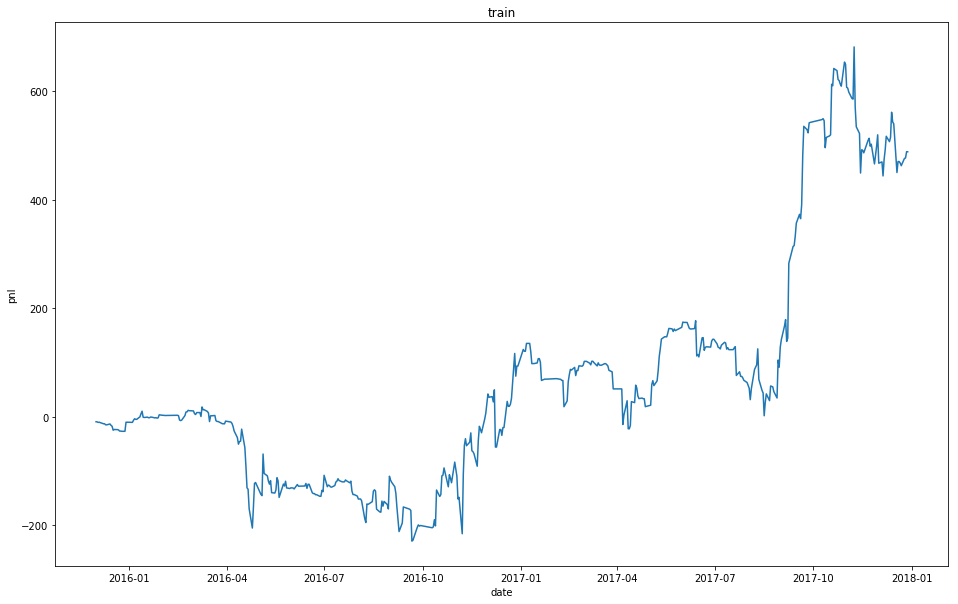

In [175]:
plt.figure(1, figsize=(16, 10))
plt.title("train")
plt.xlabel("date")
plt.ylabel("pnl")
plt.plot(format_dates[train_sample], train_pnl.cumsum());

- and the sharpe ratio

In [176]:
sharpe(train_pnl)
## 0.6896386311777737

0.6896386311777737

- now generate the result in test samples

In [177]:
%%time
with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
    f_par = functools.partial(get_signal_pnl_better, product=product, signal_name="open.int.ret.2048", thre_mat=thre_mat, 
                              reverse=1, min_spread=0.51)
    test_result = compute([delayed(f_par)(file) for file in good_night_files[test_sample]])[0]

Wall time: 41.9 s


- now we get the test statistics

In [178]:
test_stat = get_hft_summary(test_result, thre_mat, sum(test_sample))
test_stat["final.result"][good_train]

#  	open 	close 	num 	avg.pnl 	total.pnl 	sharp 	drawdown 	max.drawdown 	mar
# 2 	0.044 	-0.044 	507 	-0.557640 	-282.723250 	-0.604041 	383.244925 	806.214755 	-0.350680
# 7 	0.054 	-0.054 	262 	-2.258723 	-591.785325 	-1.523582 	612.169315 	755.264175 	-0.783547
# 8 	0.056 	-0.056 	232 	-1.748979 	-405.763070 	-1.133627 	418.709240 	533.330345 	-0.760810
# 9 	0.058 	-0.058 	198 	-0.361617 	-71.600110 	-0.213393 	244.714075 	324.620255 	-0.220566
# 10 	0.060 	-0.060 	173 	0.269131 	46.559615 	0.152250 	176.665025 	297.484820 	0.156511

,open,close,num,avg.pnl,total.pnl,sharp,drawdown,max.drawdown,mar
2,0.044,-0.044,507,-0.557640,-282.723250,-0.604041,383.244925,806.214755,-0.350680
7,0.054,-0.054,262,-2.258723,-591.785325,-1.523582,612.169315,755.264175,-0.783547
8,0.056,-0.056,232,-1.748979,-405.763070,-1.133627,418.709240,533.330345,-0.760810
9,0.058,-0.058,198,-0.361617,-71.600110,-0.213393,244.714075,324.620255,-0.220566
10,0.060,-0.060,173,0.269131,46.559615,0.152250,176.665025,297.484820,0.156511


- get the test pnl

In [179]:
test_pnl = test_stat["daily.pnl"].loc[:, good_train].sum(axis=1)/sum(good_train)

- at last we plot the selected pnl

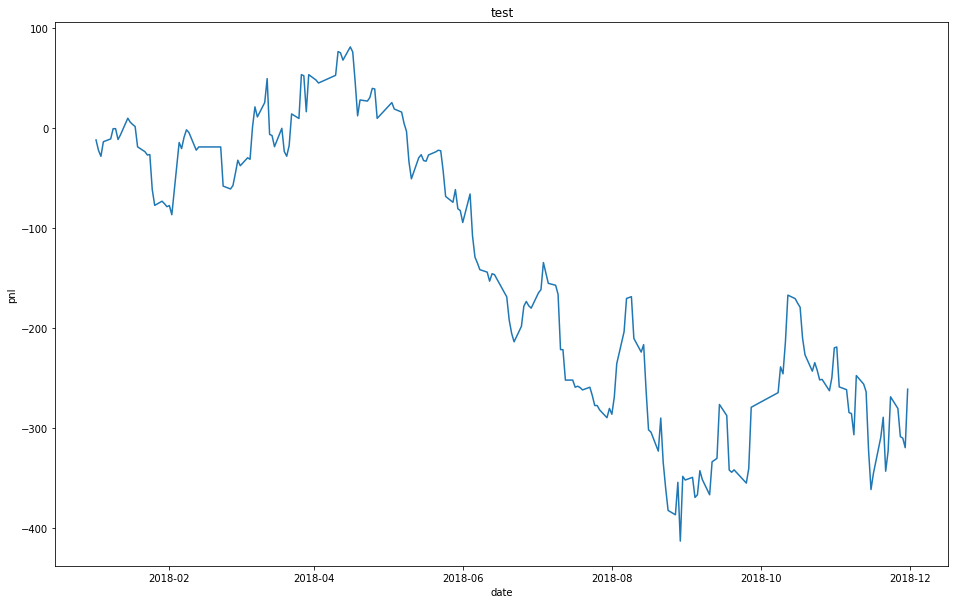

In [180]:
plt.figure(1, figsize=(16, 10))
plt.title("test")
plt.xlabel("date")
plt.ylabel("pnl")
plt.plot(format_dates[test_sample], test_pnl.cumsum());

- and the sharpe ratio

In [181]:
sharpe(test_pnl)
## [1]-0.8568081053673275

## generally speaking it's not so good
## when we are performing analysis we found that it was not as good as before
## we can try using get.signal.pnl instead of get.signal.pnl.better,
## the curves would be similar

-0.8568081053673275

- now we can try a signal using min/max
- we use a function
- get.range.pos <- function(wpr, min.period, max.period, period)
-  ewma((wpr-min.period) %0/% (max.period-min.period),period)-0.5

In [184]:
from collections import OrderedDict
class foctor_range_pos_period(factor_template):
    factor_name = "range.pos.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(10,13)))
    ])
    
    def formula(self, data, period):
        return get_range_pos(data["wpr"], data["min."+str(period)], data["max."+str(period)], period).values

- let's see waht it looks like

In [185]:
x4_1 = foctor_range_pos_period()
## actually, when period=2048, the min.period would becomes min.2048 in the build.simple.signal function
## we've changed it a little bit from week 2 by adding
## xs.new <- gsub(para.name, value, xs)    
## aa <- with(data,eval(parse(text=xs.new)))
## so be aware that the name of parameter should be complex enough to avoid error

- now we can create path

In [186]:
create_signal_path(x4_1, product, HEAD_PATH)

- then we calculate the signal

In [187]:
%%time
with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
    f_par = functools.partial(build_simple_signal, signal_list=x4_1, product=product, HEAD_PATH=HEAD_PATH)
    compute([delayed(f_par)(file) for file in good_night_list["file.path"]])

Wall time: 36.8 s


- then we can see how the signal looks like

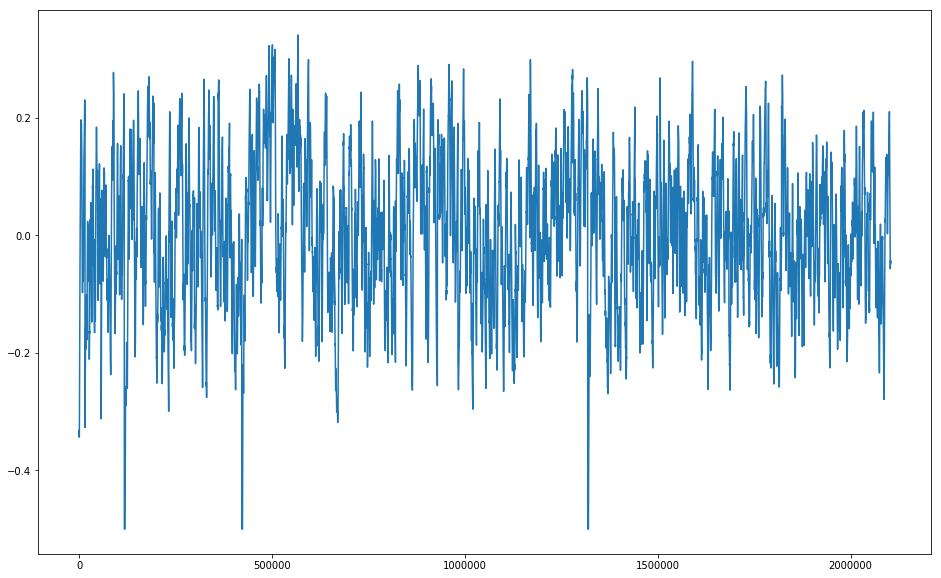

In [194]:
all_signal = get_all_signal(good_night_files, product, "range.pos.2048")
plt.figure(1, figsize=(16, 10))
plt.plot(all_signal);

- there is no extreme values

In [195]:
open_thre = np.arange(0.1, 0.32, 0.02)
thre_mat = pd.DataFrame(data=OrderedDict([("open", open_thre), ("close", -open_thre)]))

In [192]:
%%time
with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
    f_par = functools.partial(get_signal_pnl_better, product=product, signal_name="range.pos.2048", thre_mat=thre_mat, reverse=1,
                             min_spread=0.51)
    train_result = compute([delayed(f_par)(file) for file in good_night_files[train_sample]])[0]

Wall time: 45.5 s


In [193]:
train_stat = get_hft_summary(train_result, thre_mat, sum(train_sample))
train_stat["final.result"]

#  	open 	close 	num 	avg.pnl 	total.pnl 	sharp 	drawdown 	max.drawdown 	mar
# 0 	0.10 	-0.10 	1414 	0.814832 	1152.171805 	1.021403 	37.070875 	672.742715 	1.712649
# 1 	0.12 	-0.12 	1212 	0.893196 	1082.554085 	0.965272 	131.294585 	578.698225 	1.870671
# 2 	0.14 	-0.14 	1025 	1.057012 	1083.437020 	0.973447 	90.070110 	503.475350 	2.151917
# 3 	0.16 	-0.16 	889 	0.378883 	336.826740 	0.294395 	246.178115 	613.915955 	0.548653
# 4 	0.18 	-0.18 	758 	-0.065714 	-49.810925 	-0.045882 	300.315650 	830.210670 	-0.059998
# 5 	0.20 	-0.20 	610 	0.342387 	208.855815 	0.193340 	235.976185 	875.808965 	0.238472
# 6 	0.22 	-0.22 	486 	0.195607 	95.065220 	0.098167 	254.398275 	811.796295 	0.117105
# 7 	0.24 	-0.24 	370 	0.656975 	243.080695 	0.285762 	208.317590 	379.276440 	0.640906
# 8 	0.26 	-0.26 	261 	0.026736 	6.977980 	0.010142 	66.001225 	417.013990 	0.016733
# 9 	0.28 	-0.28 	173 	0.924064 	159.863085 	0.286079 	6.118125 	308.106090 	0.518857
# 10 	0.30 	-0.30 	101 	2.418871 	244.305945 	0.486496 	86.847050 	256.068885 	0.954063

,open,close,num,avg.pnl,total.pnl,sharp,drawdown,max.drawdown,mar
0,0.10,-0.10,1414,0.814832,1152.171805,1.021403,37.070875,672.742715,1.712649
1,0.12,-0.12,1212,0.893196,1082.554085,0.965272,131.294585,578.698225,1.870671
2,0.14,-0.14,1025,1.057012,1083.437020,0.973447,90.070110,503.475350,2.151917
3,0.16,-0.16,889,0.378883,336.826740,0.294395,246.178115,613.915955,0.548653
4,0.18,-0.18,758,-0.065714,-49.810925,-0.045882,300.315650,830.210670,-0.059998
5,0.20,-0.20,610,0.342387,208.855815,0.193340,235.976185,875.808965,0.238472
6,0.22,-0.22,486,0.195607,95.065220,0.098167,254.398275,811.796295,0.117105
7,0.24,-0.24,370,0.656975,243.080695,0.285762,208.317590,379.276440,0.640906
8,0.26,-0.26,261,0.026736,6.977980,0.010142,66.001225,417.013990,0.016733
9,0.28,-0.28,173,0.924064,159.863085,0.286079,6.118125,308.106090,0.518857


- select the good strategies

In [196]:
good_train = train_stat["final.result"]["avg.pnl"]>1
good_train[good_train]
## [1]  7  8  9 10 11

2     True
10    True
Name: avg.pnl, dtype: bool

- now we use a new function get.signal.stat.better to get a better estimate of the pnl

good strategies: 
 2     True
10    True
Name: avg.pnl, dtype: bool 

train sharpe:  1.0218370070375173 

test sharpe:  0.945788973880029 

Wall time: 1min 4s


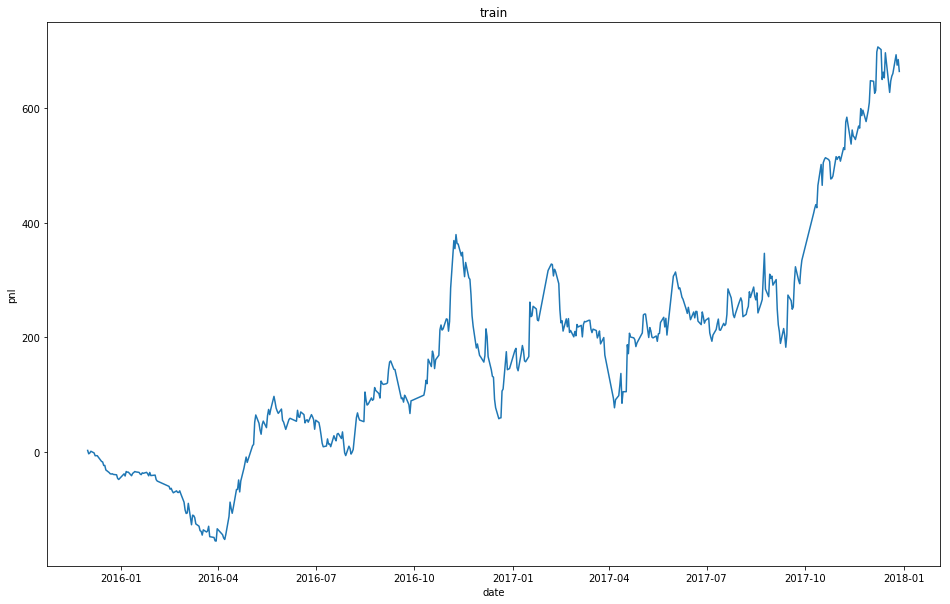

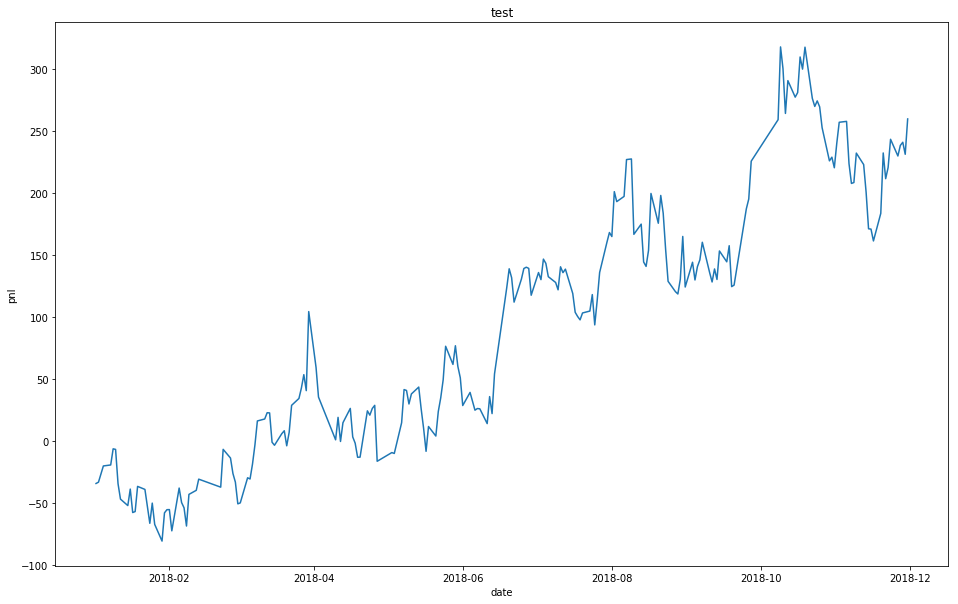

In [200]:
%%time
signal_stat = get_signal_stat_better("range.pos.2048", thre_mat, product, good_night_files, min_pnl=1, min_spread=0.51,
                                     CORE_NUM=CORE_NUM)
    
# good strategies: 
#  2     True
# 10    True
# Name: avg.pnl, dtype: bool 

# train sharpe:  1.0218370070375173 

# test sharpe:  0.945788973880029 

# Wall time: 1min 4s

- before the last signal, let's do some analysis of skewness and kurtosis

In [204]:
range_pos_signal = get_all_signal(good_night_files, product, "range.pos.2048")
nr_signal = get_all_signal(good_night_files, product, "nr.2048")
nr_vanish_signal = get_all_signal(good_night_files, product, "nr.vanish.2048")
dbook_signal = get_all_signal(good_night_files, product, "dbook.2048")
open_int_ret_signal = get_all_signal(good_night_files, product, "open.int.ret.vanish.2048")

In [205]:
from scipy.stats import kurtosis
from scipy.stats import skew

In [206]:
print("range_pos_signal")
print("kurtosis=", kurtosis(range_pos_signal, fisher=False), " skew=", skew(range_pos_signal))
# range_pos_signal
# kurtosis= 3.092685115911082  skew= -0.19086147636938203

range_pos_signal
kurtosis= 3.092685115911082  skew= -0.19086147636938203


In [207]:
print("nr_signal")
print("kurtosis=", kurtosis(nr_signal, fisher=False), " skew=", skew(nr_signal))
# nr_signal
# kurtosis= 25.75930919536833  skew= 0.8088324132226413

nr_signal
kurtosis= 25.75930919536833  skew= 0.8088324132226413


In [208]:
print("nr_vanish_signal")
print("kurtosis=", kurtosis(nr_vanish_signal, fisher=False), " skew=", skew(nr_vanish_signal))
# nr_vanish_signal
# kurtosis= 4.33067030467789  skew= 0.13170766476068088

nr_vanish_signal
kurtosis= 4.33067030467789  skew= 0.13170766476068088


In [211]:
print("dbook_signal")
print("kurtosis=", kurtosis(dbook_signal, fisher=False), " skew=", skew(dbook_signal))
# dbook_signal
# kurtosis= 3.6886679178229373  skew= -0.05962749206599482

dbook_signal
kurtosis= 3.6886679178229373  skew= -0.05962749206599482


In [214]:
print("open_int_ret_signal")
print("kurtosis=", kurtosis(open_int_ret_signal, fisher=False), " skew=", skew(open_int_ret_signal))
# open_int_ret_signal
# kurtosis= 3.1949627955466235  skew= -0.06622451791453238

open_int_ret_signal
kurtosis= 3.1949627955466235  skew= -0.06622451791453238


- we know that standard normal distribution is 3, so 3.29 is a little bit higher but still close to normal distribution
- as we see above, range.pos.signal and dbook.signal are good signals, they have kurtosis of slightly above 3
- open.int.ret.signal and nr.signal are not good signals, and they have kurtosis above 8
- nr.vanish.signal is better than nr.signal, and it has kurtosis much lower
- so when we want to improve our signals, we can focus on how to decrease the kurtosis


- kurtosis is used to measure fatness and thiness of the shape of the density distribution
- financial has fat tails, which may lead to large kurtosis value
- so we can use vanish techniques to reduce it 

- the last signal we can use some technical indicators, here we use rsi


- rsi  considers the rise movements and drop movements and calcualtes their ratio
- here we slightly change it to make it easier to calcualte

In [215]:
def rsi(ret, period):
    abs_move = np.abs(ret)
    up_move = np.maximum(ret, 0)
    up_total = ewma(up_move, period)
    move_total = ewma(abs_move, period)
    rsi = zero_divide(up_total, move_total) - 0.5
    return rsi

- now we define the signal

In [216]:
from collections import OrderedDict
class foctor_rsi_period(factor_template):
    factor_name = "rsi.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(10,13)))
    ])
    
    def formula(self, data, period):
        return rsi(data["ret"], period).values

In [217]:
x8 = foctor_rsi_period()

- create directory for the signal

In [218]:
create_signal_path(x8, product, HEAD_PATH)

In [219]:
%%time
with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
    f_par = functools.partial(build_simple_signal, signal_list=x8, product=product, HEAD_PATH=HEAD_PATH)
    compute([delayed(f_par)(file) for file in good_night_list["file.path"]])

Wall time: 42.2 s


rsi_signal
kurtosis= 29.048468121610423  skew= 0.7197608324253814
rsi_vanish_signal
kurtosis= 3.689083192959946  skew= 0.003432463201311683


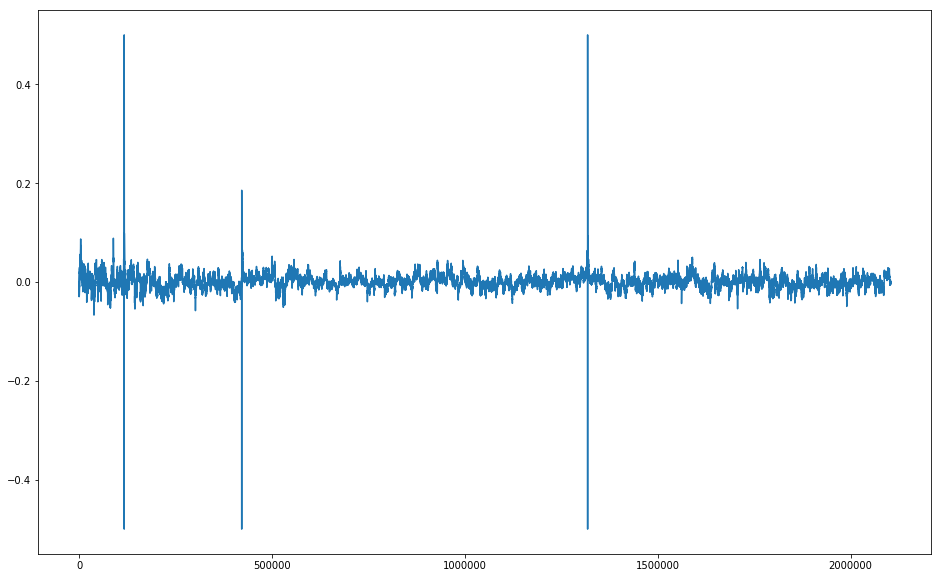

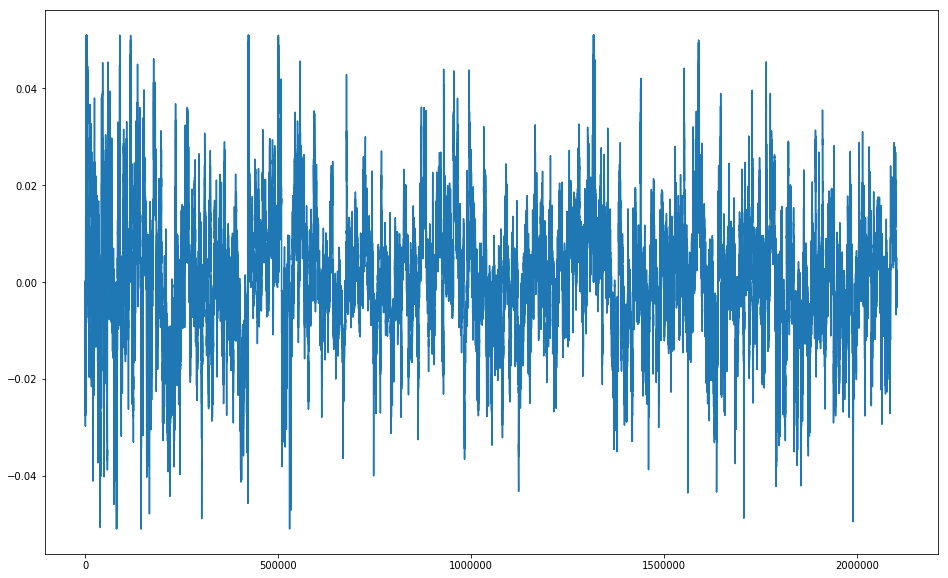

In [221]:
rsi_signal = get_all_signal(good_night_files, product, "rsi.2048")
plt.figure(1, figsize=(16, 10))
plt.plot(rsi_signal)
print("rsi_signal")
print("kurtosis=", kurtosis(rsi_signal, fisher=False), " skew=", skew(rsi_signal))
rsi_vanish_signal = vanish_thre(rsi_signal,0.051)
plt.figure(2, figsize=(16, 10))
plt.plot(rsi_vanish_signal)
print("rsi_vanish_signal")
print("kurtosis=", kurtosis(rsi_vanish_signal, fisher=False), " skew=", skew(rsi_vanish_signal))
# rsi_signal
# kurtosis= 29.048468121610423  skew= 0.7197608324253814
# rsi_vanish_signal
# kurtosis= 3.689083192959946  skew= 0.003432463201311683

- so we use this rsi.vanish and build the signal again

In [229]:
from collections import OrderedDict
class foctor_rsi_vanish_period(factor_template):
    factor_name = "rsi.vanish.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(10,13)))
    ])
    
    def formula(self, data, period):
        return vanish_thre(rsi(data["ret"], period), 0.051).values

In [230]:
x8_1 = foctor_rsi_vanish_period()

In [231]:
create_signal_path(x8_1, product, HEAD_PATH)

In [232]:
%%time
with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
    f_par = functools.partial(build_simple_signal, signal_list=x8_1, product=product, HEAD_PATH=HEAD_PATH)
    compute([delayed(f_par)(file) for file in good_night_list["file.path"]])

Wall time: 40 s


In [233]:
open_thre = np.arange(0.03, 0.051, 0.001)
thre_mat = pd.DataFrame(data=OrderedDict([("open", open_thre), ("close", -open_thre)]))

In [234]:
%%time
with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
    f_par = functools.partial(get_signal_pnl_better, product=product, signal_name="rsi.vanish.2048", thre_mat=thre_mat, reverse=1)
    train_result = compute([delayed(f_par)(file) for file in good_night_files[train_sample]])[0]

Wall time: 45.5 s


In [235]:
train_stat = get_hft_summary(train_result, thre_mat, sum(train_sample))
train_stat["final.result"]

# open 	close 	num 	avg.pnl 	total.pnl 	sharp 	drawdown 	max.drawdown 	mar
# 0 	0.030 	-0.030 	506 	0.318768 	161.296825 	0.187610 	133.120815 	532.457195 	0.302929
# 1 	0.031 	-0.031 	482 	0.096065 	46.303385 	0.054558 	141.120815 	582.703605 	0.079463
# 2 	0.032 	-0.032 	446 	0.046487 	20.733150 	0.025577 	215.854375 	614.193980 	0.033757
# 3 	0.033 	-0.033 	420 	-0.136246 	-57.223210 	-0.070432 	235.504980 	711.195850 	-0.080461
# 4 	0.034 	-0.034 	387 	0.062981 	24.373745 	0.032081 	163.985170 	689.784650 	0.035335
# 5 	0.035 	-0.035 	369 	0.041226 	15.212540 	0.020988 	202.339440 	731.091870 	0.020808
# 6 	0.036 	-0.036 	346 	0.046138 	15.963890 	0.022455 	256.794255 	723.375770 	0.022069
# 7 	0.037 	-0.037 	328 	-0.621533 	-203.862700 	-0.296779 	458.393610 	838.536255 	-0.243117
# 8 	0.038 	-0.038 	302 	-0.401027 	-121.110210 	-0.187090 	274.479655 	595.354625 	-0.203425
# 9 	0.039 	-0.039 	287 	-1.092916 	-313.666865 	-0.474772 	379.005415 	632.483430 	-0.495929
# 10 	0.040 	-0.040 	264 	-1.145772 	-302.483870 	-0.487749 	399.603655 	519.436890 	-0.582330
# 11 	0.041 	-0.041 	239 	-0.218070 	-52.118820 	-0.090502 	186.720650 	455.731340 	-0.114363
# 12 	0.042 	-0.042 	226 	0.400993 	90.624480 	0.166049 	55.439230 	404.338420 	0.224130
# 13 	0.043 	-0.043 	213 	0.451709 	96.213995 	0.184686 	84.901895 	436.337320 	0.220504
# 14 	0.044 	-0.044 	191 	0.436398 	83.351995 	0.162392 	82.781515 	405.160325 	0.205726
# 15 	0.045 	-0.045 	175 	1.159684 	202.944705 	0.411850 	61.962230 	412.160655 	0.492392
# 16 	0.046 	-0.046 	161 	0.868716 	139.863235 	0.285825 	71.267675 	447.686115 	0.312414
# 17 	0.047 	-0.047 	145 	0.194524 	28.205925 	0.058111 	112.859660 	402.540690 	0.070070
# 18 	0.048 	-0.048 	135 	0.364737 	49.239500 	0.104902 	76.618535 	411.262830 	0.119728
# 19 	0.049 	-0.049 	123 	-0.645443 	-79.389445 	-0.171849 	187.263005 	399.322555 	-0.198810
# 20 	0.050 	-0.050 	108 	-0.675578 	-72.962400 	-0.162879 	166.667060 	375.089280 	-0.194520

,open,close,num,avg.pnl,total.pnl,sharp,drawdown,max.drawdown,mar
0,0.030,-0.030,506,0.318768,161.296825,0.187610,133.120815,532.457195,0.302929
1,0.031,-0.031,482,0.096065,46.303385,0.054558,141.120815,582.703605,0.079463
2,0.032,-0.032,446,0.046487,20.733150,0.025577,215.854375,614.193980,0.033757
3,0.033,-0.033,420,-0.136246,-57.223210,-0.070432,235.504980,711.195850,-0.080461
4,0.034,-0.034,387,0.062981,24.373745,0.032081,163.985170,689.784650,0.035335
5,0.035,-0.035,369,0.041226,15.212540,0.020988,202.339440,731.091870,0.020808
6,0.036,-0.036,346,0.046138,15.963890,0.022455,256.794255,723.375770,0.022069
7,0.037,-0.037,328,-0.621533,-203.862700,-0.296779,458.393610,838.536255,-0.243117
8,0.038,-0.038,302,-0.401027,-121.110210,-0.187090,274.479655,595.354625,-0.203425
9,0.039,-0.039,287,-1.092916,-313.666865,-0.474772,379.005415,632.483430,-0.495929


- The result is not good
- we can still try rsi.4096

In [236]:
%%time
with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
    f_par = functools.partial(get_signal_pnl_better, product=product, signal_name="rsi.vanish.4096", thre_mat=thre_mat, reverse=1)
    train_result = compute([delayed(f_par)(file) for file in good_night_files[train_sample]])[0]

Wall time: 29.3 s


In [237]:
train_stat = get_hft_summary(train_result, thre_mat, sum(train_sample))
train_stat["final.result"]
#  	open 	close 	num 	avg.pnl 	total.pnl 	sharp 	drawdown 	max.drawdown 	mar
# 0 	0.030 	-0.030 	159 	1.779713 	282.974340 	0.562462 	126.266790 	451.273070 	0.627058
# 1 	0.031 	-0.031 	143 	1.697708 	242.772200 	0.488904 	133.213425 	400.091235 	0.606792
# 2 	0.032 	-0.032 	131 	1.068334 	139.951760 	0.294116 	167.677255 	348.784325 	0.401256
# 3 	0.033 	-0.033 	119 	3.550842 	422.550185 	1.131609 	76.558605 	92.919925 	4.547466
# 4 	0.034 	-0.034 	114 	2.071505 	236.151560 	0.631740 	113.736705 	119.098355 	1.982828
# 5 	0.035 	-0.035 	107 	1.512857 	161.875700 	0.440205 	135.947565 	135.947565 	1.190722
# 6 	0.036 	-0.036 	98 	2.153650 	211.057655 	0.598972 	166.490295 	166.490295 	1.267687
# 7 	0.037 	-0.037 	92 	2.383191 	219.253575 	0.630053 	155.012015 	155.012015 	1.414430
# 8 	0.038 	-0.038 	84 	2.273180 	190.947135 	0.548956 	142.680475 	142.680475 	1.338285
# 9 	0.039 	-0.039 	80 	2.241106 	179.288470 	0.515753 	154.289205 	154.289205 	1.162029
# 10 	0.040 	-0.040 	76 	2.844344 	216.170125 	0.628920 	114.355970 	122.744485 	1.761139
# 11 	0.041 	-0.041 	67 	4.168081 	279.261445 	0.829383 	92.919925 	123.744375 	2.256761
# 12 	0.042 	-0.042 	61 	5.342360 	325.883940 	0.982073 	92.919925 	127.244320 	2.561088
# 13 	0.043 	-0.043 	59 	4.250749 	250.794185 	0.782276 	92.919925 	131.244540 	1.910892
# 14 	0.044 	-0.044 	56 	4.039914 	226.235175 	0.732664 	92.919925 	131.744595 	1.717225
# 15 	0.045 	-0.045 	52 	3.565699 	185.416350 	0.608587 	92.919925 	135.744815 	1.365918
# 16 	0.046 	-0.046 	49 	2.868520 	140.557485 	0.445274 	92.919925 	155.030605 	0.906643
# 17 	0.047 	-0.047 	44 	3.698961 	162.754285 	0.517356 	92.919925 	136.844040 	1.189341
# 18 	0.048 	-0.048 	43 	2.940944 	126.460590 	0.409753 	92.919925 	141.641200 	0.892823
# 19 	0.049 	-0.049 	42 	3.301277 	138.653640 	0.452818 	92.919925 	116.947875 	1.185602
# 20 	0.050 	-0.050 	41 	1.824153 	74.790260 	0.230980 	92.919925 	170.453650 	0.438772

,open,close,num,avg.pnl,total.pnl,sharp,drawdown,max.drawdown,mar
0,0.030,-0.030,159,1.779713,282.974340,0.562462,126.266790,451.273070,0.627058
1,0.031,-0.031,143,1.697708,242.772200,0.488904,133.213425,400.091235,0.606792
2,0.032,-0.032,131,1.068334,139.951760,0.294116,167.677255,348.784325,0.401256
3,0.033,-0.033,119,3.550842,422.550185,1.131609,76.558605,92.919925,4.547466
4,0.034,-0.034,114,2.071505,236.151560,0.631740,113.736705,119.098355,1.982828
5,0.035,-0.035,107,1.512857,161.875700,0.440205,135.947565,135.947565,1.190722
6,0.036,-0.036,98,2.153650,211.057655,0.598972,166.490295,166.490295,1.267687
7,0.037,-0.037,92,2.383191,219.253575,0.630053,155.012015,155.012015,1.414430
8,0.038,-0.038,84,2.273180,190.947135,0.548956,142.680475,142.680475,1.338285
9,0.039,-0.039,80,2.241106,179.288470,0.515753,154.289205,154.289205,1.162029


In [239]:
good_train = train_stat["final.result"]["avg.pnl"]>2
good_train[good_train]
# 3     True
# 4     True
# 6     True
# 7     True
# 8     True
# 9     True
# 10    True
# 11    True
# 12    True
# 13    True
# 14    True
# 15    True
# 16    True
# 17    True
# 18    True
# 19    True
# Name: avg.pnl, dtype: bool

3     True
4     True
6     True
7     True
8     True
9     True
10    True
11    True
12    True
13    True
14    True
15    True
16    True
17    True
18    True
19    True
Name: avg.pnl, dtype: bool

In [263]:
train_stat = get_hft_summary(train_result, thre_mat, sum(train_sample))
train_stat["final.result"][good_train]


,open,close,num,avg.pnl,total.pnl,sharp,drawdown,max.drawdown,mar
3,0.033,-0.033,119,3.550842,422.550185,1.131609,76.558605,92.919925,4.547466
4,0.034,-0.034,114,2.071505,236.151560,0.631740,113.736705,119.098355,1.982828
6,0.036,-0.036,98,2.153650,211.057655,0.598972,166.490295,166.490295,1.267687
7,0.037,-0.037,92,2.383191,219.253575,0.630053,155.012015,155.012015,1.414430
8,0.038,-0.038,84,2.273180,190.947135,0.548956,142.680475,142.680475,1.338285
9,0.039,-0.039,80,2.241106,179.288470,0.515753,154.289205,154.289205,1.162029
10,0.040,-0.040,76,2.844344,216.170125,0.628920,114.355970,122.744485,1.761139
11,0.041,-0.041,67,4.168081,279.261445,0.829383,92.919925,123.744375,2.256761
12,0.042,-0.042,61,5.342360,325.883940,0.982073,92.919925,127.244320,2.561088
13,0.043,-0.043,59,4.250749,250.794185,0.782276,92.919925,131.244540,1.910892


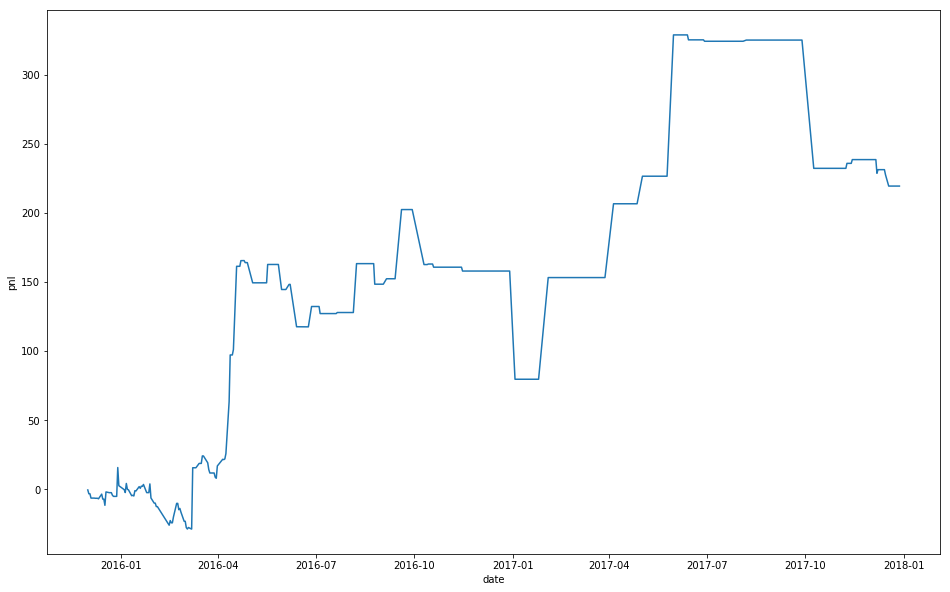

In [266]:
train_pnl = train_stat["daily.pnl"].loc[:, good_train].sum(axis=1)/sum(good_train)
plt.figure(1, figsize=(16, 10))
plt.title("")
plt.xlabel("date")
plt.ylabel("pnl")
date_str = [n[0:8] for n in good_night_files]
format_dates = np.array([pd.to_datetime(d) for d in date_str])
plt.plot(format_dates[train_sample], train_pnl.cumsum());

In [267]:
sharpe(train_pnl)
## 0.6907236383381612

0.6907236383381612

In [245]:
%%time
with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
    f_par = functools.partial(get_signal_pnl, product=product, signal_name="rsi.vanish.4096", thre_mat=thre_mat, reverse=1)
    test_result = compute([delayed(f_par)(file) for file in good_night_files[test_sample]])[0]

Wall time: 17.1 s


In [261]:
test_stat = get_hft_summary(test_result, thre_mat, sum(test_sample))
test_stat["final.result"][good_train]


,open,close,num,avg.pnl,total.pnl,sharp,drawdown,max.drawdown,mar
3,0.033,-0.033,42,5.667602,238.039290,1.514152,47.522740,74.067985,3.213795
4,0.034,-0.034,37,4.280668,158.384710,1.030859,50.022795,79.567380,1.990573
6,0.036,-0.036,29,0.250702,7.270350,0.041324,104.238355,133.206175,0.054580
7,0.037,-0.037,25,0.267253,6.681325,0.038470,91.328095,112.331560,0.059479
8,0.038,-0.038,24,-2.659787,-63.834895,-0.367047,142.843765,153.834830,-0.414957
9,0.039,-0.039,22,-5.334826,-117.366180,-0.662305,186.511695,194.003035,-0.604971
10,0.040,-0.040,19,-8.473990,-161.005810,-0.888568,230.151325,253.125565,-0.636071
11,0.041,-0.041,18,-8.336760,-150.061685,-0.838927,218.620475,241.594715,-0.621130
12,0.042,-0.042,15,-2.875127,-43.126900,-0.270176,111.685690,151.160420,-0.285306
13,0.043,-0.043,14,-2.012474,-28.174635,-0.153255,96.733425,159.205625,-0.176970


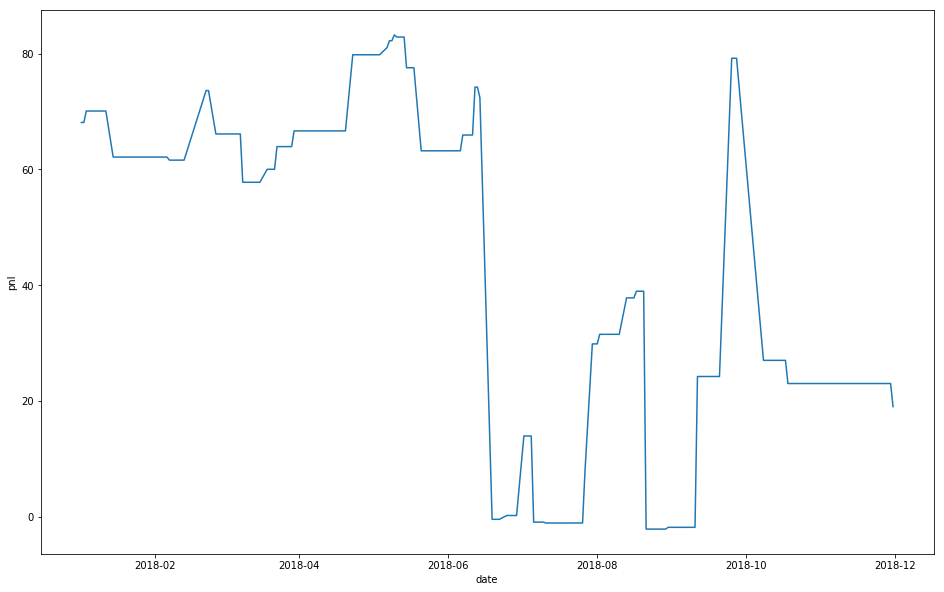

In [262]:
test_pnl = test_stat["daily.pnl"].loc[:, good_train].sum(axis=1)/sum(good_train)
plt.figure(1, figsize=(16, 10))
plt.title("")
plt.xlabel("date")
plt.ylabel("pnl")
date_str = [n[0:8] for n in good_night_files]
format_dates = np.array([pd.to_datetime(d) for d in date_str])
plt.plot(format_dates[test_sample], test_pnl.cumsum());

In [268]:
sharpe(test_pnl)
## 0.14457927792084102

0.14457927792084102

- homework
- try using period=1024,4096 to test all of the signals this week
- test their kurtosis, then use vanish threshold when necessary
- you simply need to save the final result
- for example, nr.4096.train.stat, nr.4096.test.stat
- even if it uses vanish, you don't need to use nr.vanish.4096, just keep the original name is OK